In [1]:
# TODO:
# - annotate nicely
# - try again with older h2o

## License 

Copyright 2020 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

# Building Accurate Interpretable Models Automatically

#### Automatic Parsimonious Hybrids (autoPH) ;)

A modeling approach that synthesizes public ideas from the Bank of England and the 2004 KDD Cup:

https://www.bankofengland.co.uk/working-paper/2019/machine-learning-explainability-in-finance-an-application-to-default-risk-analysis

https://dl.acm.org/doi/pdf/10.1145/1046456.1046470

#### Global hyperameters

In [50]:
SEED                    = 12345 # global random seed for better reproducibility
GLM_SELECTION_THRESHOLD = 0.001 # threshold above which a feature is considered "selected"
MONO_THRESHOLD          = 6     # threshold at or above which a feature is considered monotonic

#### Python imports 

In [3]:
import auto_ph 
import h2o                                                        # import h2o python bindings to java server
from h2o.estimators.glm import H2OGeneralizedLinearEstimator      # for benchmark model
from h2o.grid.grid_search import H2OGridSearch                    # for grid searches
from h2o.estimators.gbm import H2OGradientBoostingEstimator       # for MGBM/GBM
import numpy as np                                                # array, vector, matrix calculations
import pandas as pd                                               # DataFrame handling
import shap                                                       # for consistent, signed feature importance measurements
import time                                                       # for timers

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

np.random.seed(SEED)         # set random seed for reproducibility

h2o.init(max_mem_size='16G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o's memory
h2o.no_progress()                        # turn of h2o progress indicators    

/home/patrickh/Workspace/interpretable_machine_learning_with_python/env_iml/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_242"; OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~18.04-b08); OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)
  Starting server from /home/patrickh/Workspace/interpretable_machine_learning_with_python/env_iml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpaxilkuwq
  JVM stdout: /tmp/tmpaxilkuwq/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpaxilkuwq/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       America/New_York
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.3
H2O cluster version age:    7 months and 29 days !!!
H2O cluster name:           H2O_from_python_patrickh_3zdh36
H2O cluster total nodes:    1
H2O cluster free memory:    14.22 Gb
H2O cluster total cores:    24
H2O cluster allowed cores:  4
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.9 final
--------------------------  ---------------------------------------------------

#### Start global timer

In [4]:
big_tic = time.time()

## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input features: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input features are used to predict the target feature, whether or not a customer defaulted on their credit card bill in late 2005.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`. 

In [5]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input features in the credit card default data except the row indentifier, `ID`.

In [6]:
# assign target and inputs for GBM
y_name = 'DEFAULT_NEXT_MONTH'
x_names = [name for name in data.columns if name not in [y_name, 'ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]
print('y_name =', y_name)
print('x_names =', x_names)

y_name = DEFAULT_NEXT_MONTH
x_names = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input features `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`-`PAY_6`, and the prediction target `DEFAULT_NEXT_MONTH`, are really categorical features, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [7]:
data[x_names + [y_name]].describe() # display descriptive statistics for all columns

LIMIT_BAL         PAY_0         PAY_2         PAY_3         PAY_4  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667     -0.016700     -0.133767     -0.166200     -0.220667   
std     129747.661567      1.123802      1.197186      1.196868      1.169139   
min      10000.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%      50000.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%     140000.000000      0.000000      0.000000      0.000000      0.000000   
75%     240000.000000      0.000000      0.000000      0.000000      0.000000   
max    1000000.000000      8.000000      8.000000      8.000000      8.000000   

              PAY_5         PAY_6      BILL_AMT1      BILL_AMT2     BILL_AMT3  \
count  30000.000000  30000.000000   30000.000000   30000.000000  3.000000e+04   
mean      -0.266200     -0.291100   51223.330900   49179.075167  4.701315e+04   
std        1.133187      1.149988   73635.860576   71173.768783  6.934939e+04   
min       -2.000000     -2.000000 -165580.000000  -69777.000000 -1.572640e+05   
25%       -1.000000     -1.000000    3558.750000    2984.750000  2.666250e+03   
50%        0.000000      0.000000   22381.500000   21200.000000  2.008850e+04   
75%        0.000000      0.000000   67091.000000   64006.250000  6.016475e+04   
max        8.000000      8.000000  964511.000000  983931.000000  1.664089e+06   

           BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count   30000.000000   30000.000000   30000.000000   30000.000000   
mean    43262.948967   40311.400967   38871.760400    5663.580500   
std     64332.856134   60797.155770   59554.107537   16563.280354   
min   -170000.000000  -81334.000000 -339603.000000       0.000000   
25%      2326.750000    1763.000000    1256.000000    1000.000000   
50%     19052.000000   18104.500000   17071.000000    2100.000000   
75%     54506.000000   50190.500000   49198.250000    5006.000000   
max    891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6  DEFAULT_NEXT_MONTH  
count   30000.000000        30000.000000  
mean     5215.502567            0.221200  
std     17777.465775            0.415062  
min         0.000000            0.000000  
25%       117.750000            0.000000  
50%      1500.000000            0.000000  
75%      4000.000000            0.000000  
max    528666.000000            1.000000

## 2. Investigate pair-wise Pearson correlations for DEFAULT_NEXT_MONTH

#### Calculate and plot Pearson correlation

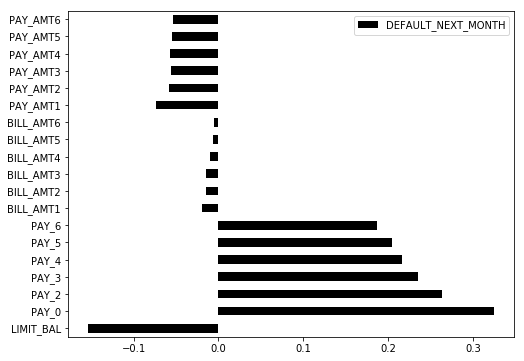

In [8]:
# Pearson correlation between inputs and target
corr = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']

# display correlation matrix as barchart
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1].plot(kind='barh', ax=ax_, colormap='gnuplot')

## 3. Train Penalized GLM for Initial Feature Selection 

#### Split data into training and validation partitions

In [9]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 20946, columns = 25
Validation data rows = 9054, columns = 25


#### Train penalized GLM for initial benchmark and feature selection 

In [10]:
# train penalized GLM w/ alpha and lambda grid search
best_glm = auto_ph.glm_grid(x_names, y_name, h2o.H2OFrame(train),
                            h2o.H2OFrame(valid), SEED)

print('Best penalized GLM AUC: %.2f' % 
      best_glm.auc(valid=True))

Best penalized GLM AUC: 0.73


#### Display best GLM information

In [11]:
best_glm 

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_b3fef3ef91f9b04386a07098384449ba.hex_model_python_1587576154135_1_model_1


GLM Model: summary


family   link                                  regularization  \
0    binomial  logit  Elastic Net (alpha = 0.01, lambda = 0.005908 )   

                                                           lambda_search  \
0  nlambda = 100, lambda.max = 13.333, lambda.min = 0.005908, lambda....   

   number_of_predictors_total number_of_active_predictors  \
0                          19                          19   

   number_of_iterations  \
0                   109   

                                           training_frame  
0  Key_Frame__upload_b3fef3ef91f9b04386a07098384449ba.hex



ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.14649158915954694
RMSE: 0.3827421967324049
LogLoss: 0.4685812636002607
Null degrees of freedom: 20945
Residual degrees of freedom: 20926
Null deviance: 22178.75361964548
Residual deviance: 19629.80629474212
AIC: 19669.80629474212
AUC: 0.7182752479663853
pr_auc: 0.5010322496049208
Gini: 0.4365504959327706

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2498310673824375: 

0       1   Error               Rate
0      0  13778.0  2518.0  0.1545   (2518.0/16296.0)
1      1   2168.0  2482.0  0.4662    (2168.0/4650.0)
2  Total  15946.0  5000.0  0.2237   (4686.0/20946.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold     value    idx
0                       max f1   0.249831  0.514404  205.0
1                       max f2   0.054654  0.594059  377.0
2                 max f0point5   0.399178  0.567555  137.0
3                 max accuracy   0.418922  0.817053  128.0
4                max precision   0.706802  0.797414   34.0
5                   max recall   0.001281  1.000000  399.0
6              max specificity   0.989212  0.999570    0.0
7             max absolute_mcc   0.399178  0.396395  137.0
8   max min_per_class_accuracy   0.221641  0.658925  237.0
9  max mean_per_class_accuracy   0.245211  0.690483  210.0


Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.20 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010026     7.192943e-01  3.539263   
1         2                  0.020004     6.109553e-01  2.952721   
2         3                  0.030030     5.904669e-01  3.303312   
3         4                  0.040008     5.652261e-01  3.469986   
4         5                  0.050033     5.378222e-01  3.024461   
5         6                  0.100019     4.442181e-01  2.916965   
6         7                  0.150005     3.537487e-01  2.090922   
7         8                  0.200038     2.655100e-01  1.427003   
8         9                  0.300010     2.382281e-01  1.015345   
9        10                  0.400029     2.224902e-01  0.672990   
10       11                  0.500000     2.030962e-01  0.537788   
11       12                  0.600019     1.763763e-01  0.485929   
12       13                  0.699990     1.357259e-01  0.686218   
13       14                  0.800010     1.134964e-01  0.724593   
14       15                  0.900076     6.434736e-02  0.477100   
15       16                  1.000000     1.134804e-08  0.553111   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.539263       0.785714  0.816889                  0.785714   
1          3.246692       0.655502  0.659815                  0.720764   
2          3.265595       0.733333  0.600522                  0.724960   
3          3.316571       0.770335  0.576997                  0.736277   
4          3.258037       0.671429  0.552092                  0.723282   
5          3.087582       0.647564  0.484561                  0.685442   
6          2.755468       0.464183  0.405265                  0.611712   
7          2.423193       0.316794  0.294731                  0.537947   
8          1.954060       0.225406  0.248630                  0.433800   
9          1.633754       0.149403  0.229921                  0.362692   
10         1.414624       0.119389  0.213314                  0.314046   
11         1.259817       0.107876  0.190730                  0.279679   
12         1.177896       0.152340  0.157265                  0.261492   
13         1.121223       0.160859  0.123743                  0.248911   
14         1.049612       0.105916  0.093489                  0.233013   
15         1.000000       0.122790  0.049839                  0.221999   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.816889      0.035484                 0.035484  253.926267   
1           0.738540      0.029462                 0.064946  195.272110   
2           0.692461      0.033118                 0.098065  230.331183   
3           0.663664      0.034624                 0.132688  246.998611   
4           0.641307      0.030323                 0.163011  202.446083   
5           0.562971      0.145806                 0.308817  191.696460   
6           0.510419      0.104516                 0.413333  109.092153   
7           0.456471      0.071398                 0.484731   42.700320   
8           0.387213      0.101505                 0.586237    1.534461   
9           0.347885      0.067312                 0.653548  -32.701024   
10          0.320979      0.053763                 0.707312  -46.221154   
11          0.299267      0.048602                 0.755914  -51.407129   
12          0.278986      0.068602                 0.824516  -31.378193   
13          0.259578      0.072473                 0.896989  -27.540719   
14          0.241113      0.047742                 0.944731  -52.289953   
15          0.222000      0.055269                 1.000000  -44.688932   

    cumulative_gain  
0        253.926267  
1        224.669182  
2        226.559516  
3        231.657094  
4        225.803743  
5        208.758242  
6        175.546785  
7        142.319316  
8         95.405967  
9         63.375397  
10        41.462366  
11        25.981653  
12        17.789625  
13    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.14363466020798762
RMSE: 0.3789916360660056
LogLoss: 0.4617337838828072
Null degrees of freedom: 9053
Residual degrees of freedom: 9034
Null deviance: 9526.71172610569
Residual deviance: 8361.075358549871
AIC: 8401.075358549871
AUC: 0.7303402396287311
pr_auc: 0.5061676572465437
Gini: 0.46068047925746214

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26072851982555734: 

0       1   Error              Rate
0      0  6083.0   985.0  0.1394    (985.0/7068.0)
1      1   921.0  1065.0  0.4637    (921.0/1986.0)
2  Total  7004.0  2050.0  0.2105   (1906.0/9054.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold     value    idx
0                       max f1   0.260729  0.527750  193.0
1                       max f2   0.116430  0.592436  329.0
2                 max f0point5   0.400670  0.576923  134.0
3                 max accuracy   0.433434  0.822288  120.0
4                max precision   0.572358  0.743386   68.0
5                   max recall   0.007410  1.000000  397.0
6              max specificity   0.989045  0.999859    0.0
7             max absolute_mcc   0.370892  0.413902  147.0
8   max min_per_class_accuracy   0.225699  0.672205  230.0
9  max mean_per_class_accuracy   0.246401  0.699498  206.0


Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.66 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010051     7.207631e-01  3.106072   
1         2                  0.020102     6.229843e-01  3.156170   
2         3                  0.030042     5.993452e-01  3.545821   
3         4                  0.040093     5.753741e-01  3.757345   
4         5                  0.050033     5.509826e-01  3.241893   
5         6                  0.100066     4.545088e-01  2.968828   
6         7                  0.149989     3.741888e-01  2.208854   
7         8                  0.200022     2.740947e-01  1.489446   
8         9                  0.299978     2.407348e-01  0.997420   
9        10                  0.400044     2.249573e-01  0.719563   
10       11                  0.500000     2.058437e-01  0.539010   
11       12                  0.599956     1.811296e-01  0.443298   
12       13                  0.700022     1.408759e-01  0.533383   
13       14                  0.799978     1.142562e-01  0.800958   
14       15                  0.899934     6.452901e-02  0.438260   
15       16                  1.000000     1.276339e-12  0.513255   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.106072       0.681319  0.813734                  0.681319   
1          3.131121       0.692308  0.663736                  0.686813   
2          3.268338       0.777778  0.607299                  0.716912   
3          3.390927       0.824176  0.587697                  0.743802   
4          3.361317       0.711111  0.562950                  0.737307   
5          3.165073       0.651214  0.496126                  0.694260   
6          2.846802       0.484513  0.414835                  0.624448   
7          2.507276       0.326711  0.315894                  0.549972   
8          2.004176       0.218785  0.253042                  0.439617   
9          1.682845       0.157837  0.232429                  0.369133   
10         1.454179       0.118232  0.215713                  0.318975   
11         1.285761       0.097238  0.194132                  0.282032   
12         1.178211       0.116998  0.162818                  0.258441   
13         1.131074       0.175691  0.125883                  0.248102   
14         1.054123       0.096133  0.094816                  0.231222   
15         1.000000       0.112583  0.049514                  0.219351   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.813734      0.031219                 0.031219  210.607218   
1           0.738735      0.031722                 0.062941  215.617011   
2           0.695245      0.035247                 0.098187  254.582075   
3           0.668284      0.037764                 0.135952  275.734537   
4           0.647357      0.032226                 0.168177  224.189325   
5           0.571741      0.148540                 0.316717  196.882815   
6           0.519516      0.110272                 0.426989  120.885357   
7           0.468582      0.074522                 0.501511   48.944599   
8           0.396762      0.099698                 0.601208   -0.258049   
9           0.355656      0.072004                 0.673212  -28.043657   
10          0.327680      0.053877                 0.727090  -46.099047   
11          0.305430      0.044310                 0.771400  -55.670244   
12          0.285044      0.053374                 0.824773  -46.661731   
13          0.265157      0.080060                 0.904834  -19.904191   
14          0.246237      0.043807                 0.948640  -56.173991   
15          0.226552      0.051360                 1.000000  -48.674496   

    cumulative_gain  
0        210.607218  
1        213.112114  
2        226.833792  
3        239.092657  
4        236.131730  
5        216.507273  
6        184.680243  
7        150.727595  
8        100.417577  
9         68.284535  
10        45.417925  
11        28.576100  
12        17.821055  
13    



Scoring History: 

timestamp    duration  iteration lambda  predictors  \
0     2020-04-22 13:22:39   0.000 sec          1  .13E2           1   
1     2020-04-22 13:22:39   0.041 sec          2  .12E2           2   
2     2020-04-22 13:22:39   0.071 sec          3  .11E2           2   
3     2020-04-22 13:22:39   0.106 sec          4   .1E2           3   
4     2020-04-22 13:22:39   0.143 sec          5  .92E1           4   
5     2020-04-22 13:22:39   0.164 sec          6  .84E1           5   
6     2020-04-22 13:22:39   0.175 sec          7  .76E1           6   
7     2020-04-22 13:22:39   0.182 sec          8   .7E1           7   
8     2020-04-22 13:22:39   0.214 sec          9  .63E1           7   
9     2020-04-22 13:22:39   0.220 sec         10  .58E1           8   
10    2020-04-22 13:22:39   0.226 sec         11  .53E1           8   
11    2020-04-22 13:22:39   0.232 sec         12  .48E1           8   
12    2020-04-22 13:22:39   0.240 sec         13  .44E1           8   
13    2020-04-22 13:22:39   0.255 sec         14   .4E1           8   
14    2020-04-22 13:22:39   0.269 sec         15  .36E1           8   
15    2020-04-22 13:22:39   0.293 sec         16  .33E1           8   
16    2020-04-22 13:22:39   0.316 sec         18   .3E1           9   
17    2020-04-22 13:22:39   0.334 sec         20  .27E1           9   
18    2020-04-22 13:22:39   0.353 sec         22  .25E1           9   
19    2020-04-22 13:22:39   0.377 sec         24  .23E1           9   

    deviance_train  deviance_test  
0         1.058854       1.052210  
1         1.058595       1.051942  
2         1.058312       1.051649  
3         1.057846       1.051165  
4         1.057200       1.050494  
5         1.056328       1.049589  
6         1.055193       1.048412  
7         1.053849       1.047023  
8         1.052407       1.045532  
9         1.050810       1.043879  
10        1.049070       1.042077  
11        1.047225       1.040165  
12        1.045279       1.038148  
13        1.043223       1.036017  
14        1.041064       1.033777  
15        1.038800       1.031428  
16        1.036416       1.028957  
17        1.033911       1.026363  
18        1.031311       1.023671  
19        1.028635       1.020899


See the whole table with table.as_data_frame()


#### Plot penalized GLM coefficient regularization path

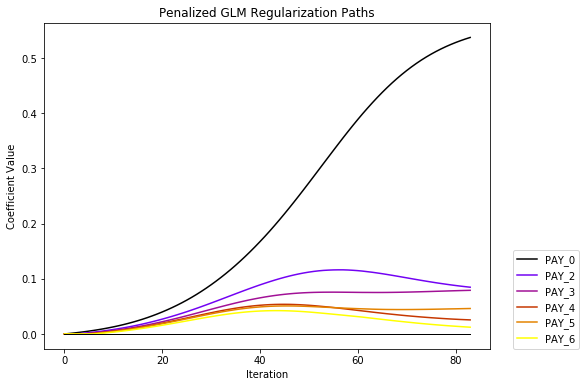

In [12]:
# collect regularization paths from dict in DataFrame
reg_path_dict = best_glm.getGLMRegularizationPath(best_glm)
reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())
for i in range(0, len(reg_path_dict['coefficients'])): 
    reg_path_frame = reg_path_frame.append(reg_path_dict['coefficients'][i], 
                                           ignore_index=True)

# establish benchmark feature selection
# glm_selected is used frequently in further calculations
glm_selected = list(reg_path_frame.iloc[-1, :][reg_path_frame.iloc[-1, :] > GLM_SELECTION_THRESHOLD].index)

# plot regularization paths
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = reg_path_frame[glm_selected].plot(kind='line', ax=ax_, title='Penalized GLM Regularization Paths',
                                      colormap='gnuplot')
_ = ax_.set_xlabel('Iteration')
_ = ax_.set_ylabel('Coefficient Value')
_ = ax_.axhline(c='k', lw=1, xmin=0.045, xmax=0.955)
_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

#### Compare model coefficients thus far

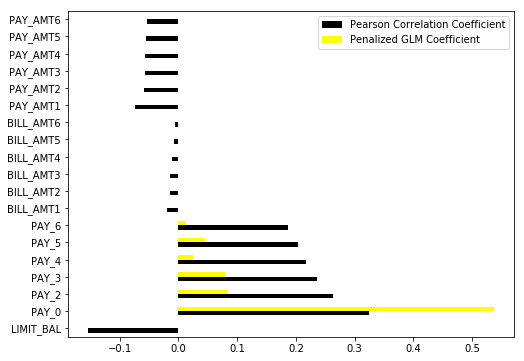

In [13]:
# collect Pearson correlation and GLM coefficients into same DataFrame
glm_selected_coef = pd.DataFrame.from_dict(best_glm.coef(), orient='index', columns=['Penalized GLM Coefficient'])
corr_glm = pd.concat([corr, glm_selected_coef.iloc[1:]], axis=1)

# plot
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = corr_glm.plot(kind='barh', ax=ax_, colormap='gnuplot')

## 4. Train Monotonic GBMs with Forward Feature Selection

#### Forward step-wise training

In [14]:
# initialize data structures needed to compare correlation coefficients,
# penalized glm coefficients, and MGBM Shapley values
# as features are added into the MGBM
abs_corr = corr.copy(deep=True)
abs_corr['Pearson Correlation Coefficient'] = corr['Pearson Correlation Coefficient'].abs()

# create a list of features to add into MGBM
# list is ordered by correlation between X_j and y
next_list = [name for name in list(abs_corr.sort_values(by='Pearson Correlation Coefficient',
                                                        ascending=False).index) if name not in glm_selected]

# create a DataFrame to store new MGBM SHAP values
# for comparison to correlation and penalized gbm coefficients
abs_corr_glm_mgbm_shap = corr_glm.copy(deep=True).abs()
abs_corr_glm_mgbm_shap.columns = ['Absolute ' + name for name in abs_corr_glm_mgbm_shap.columns]
abs_corr_glm_mgbm_shap['Monotonic GBM Mean SHAP Value'] = 0

# start local timer
tic = time.time()

# stepwise MGBM training
mgbm_models, corr_glm_mgbm_shap_coefs = auto_ph.gbm_forward_select_train(glm_selected, 
                                                                         y_name, 
                                                                         train, 
                                                                         valid, 
                                                                         SEED, 
                                                                         next_list,
                                                                         abs_corr_glm_mgbm_shap, 
                                                                         'Monotonic GBM Mean SHAP Value',
                                                                         monotone=True)
# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

# 2 threads - 695 s
# 4 threads - 691 s
# 8 threads - 692 s
# 24 threads - 713 s

Completed grid search 1/13 with AUC: 0.74 ...
Completed grid search 2/13 with AUC: 0.76 ...
Completed grid search 3/13 with AUC: 0.77 ...
Completed grid search 4/13 with AUC: 0.77 ...
Completed grid search 5/13 with AUC: 0.78 ...
Completed grid search 6/13 with AUC: 0.78 ...
Completed grid search 7/13 with AUC: 0.78 ...
Completed grid search 8/13 with AUC: 0.78 ...
Completed grid search 9/13 with AUC: 0.78 ...
Completed grid search 10/13 with AUC: 0.78 ...
Completed grid search 11/13 with AUC: 0.78 ...
Completed grid search 12/13 with AUC: 0.78 ...
Completed grid search 13/13 with AUC: 0.78 ...
Done.
Task completed in 690.96 s.


#### Compare new model feature importance to previous models

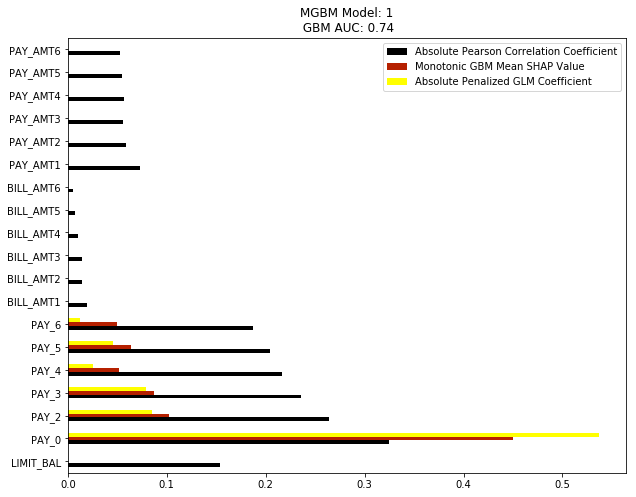

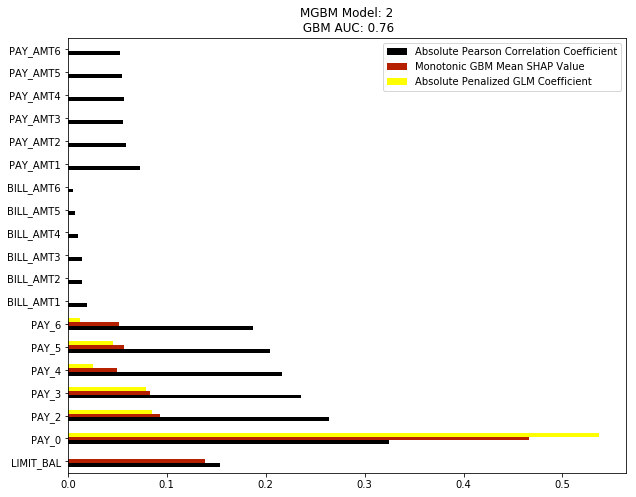

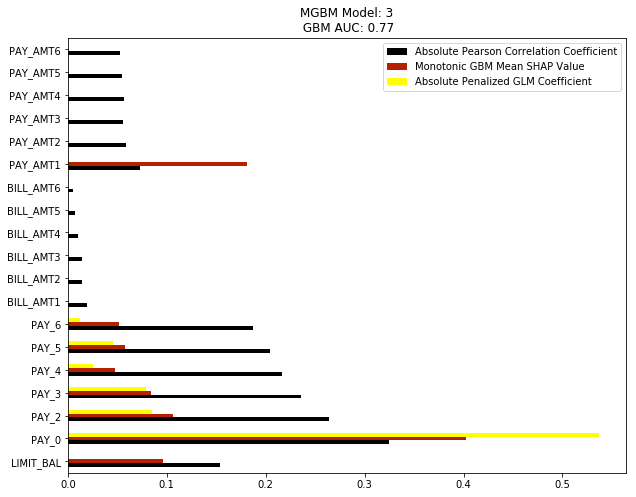

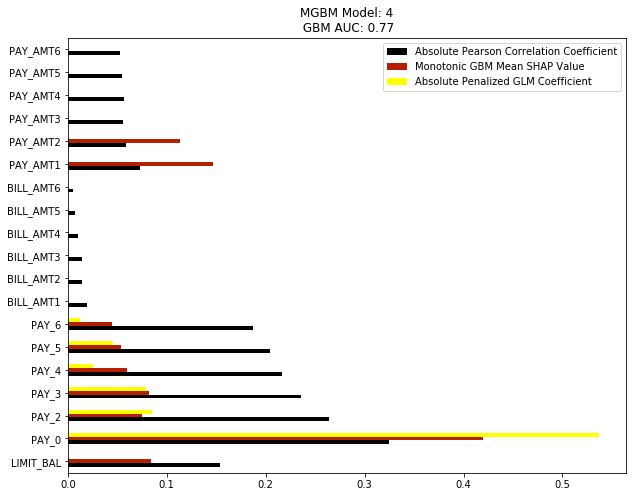

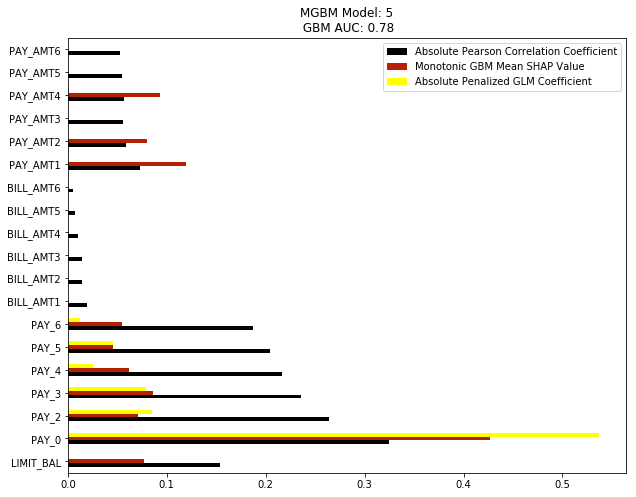

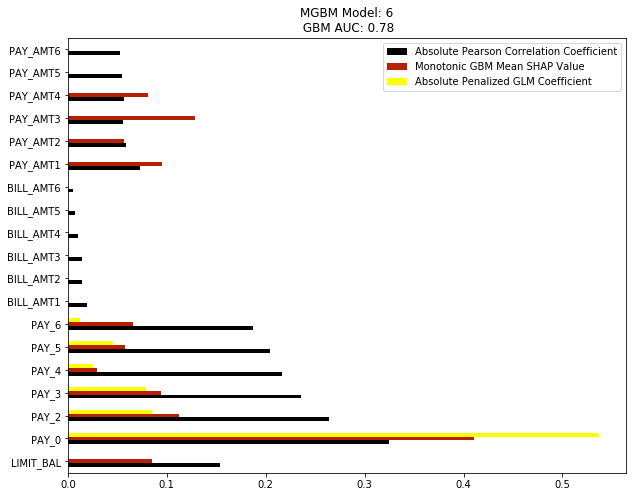

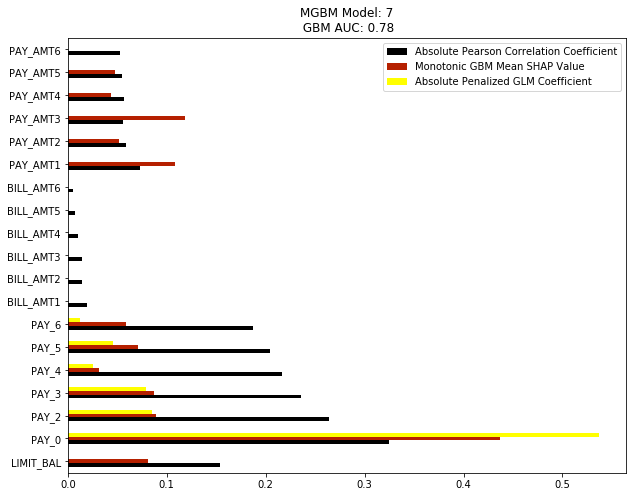

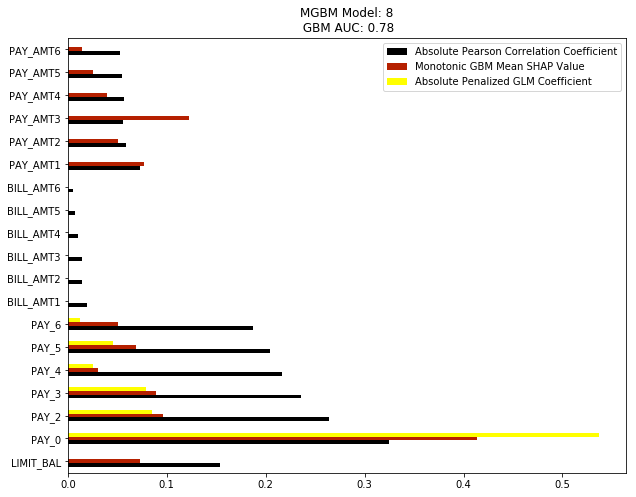

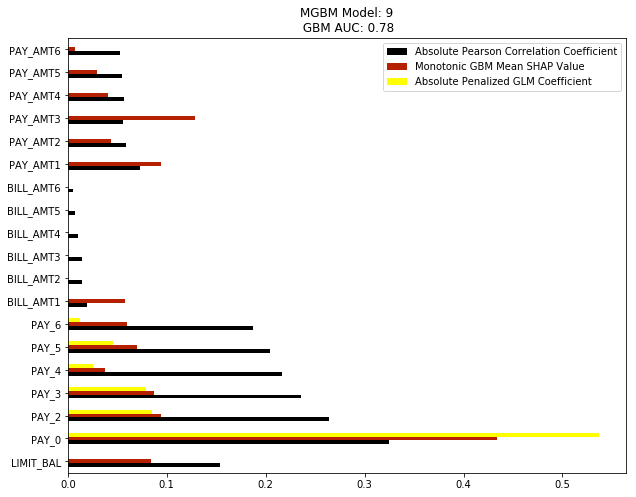

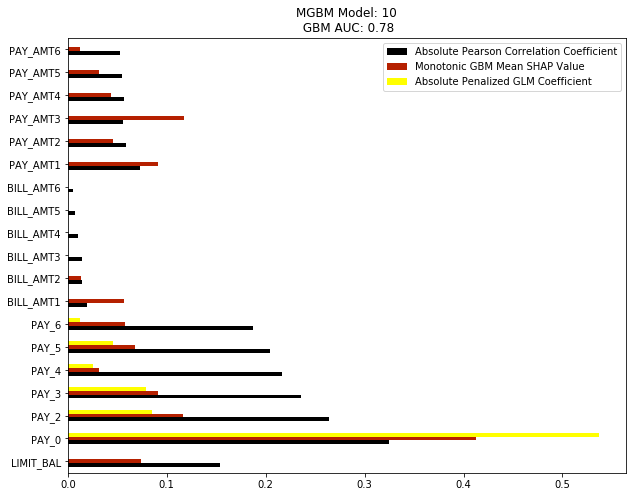

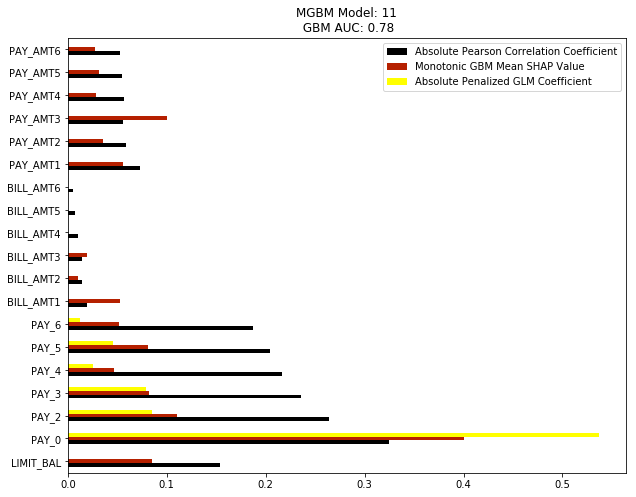

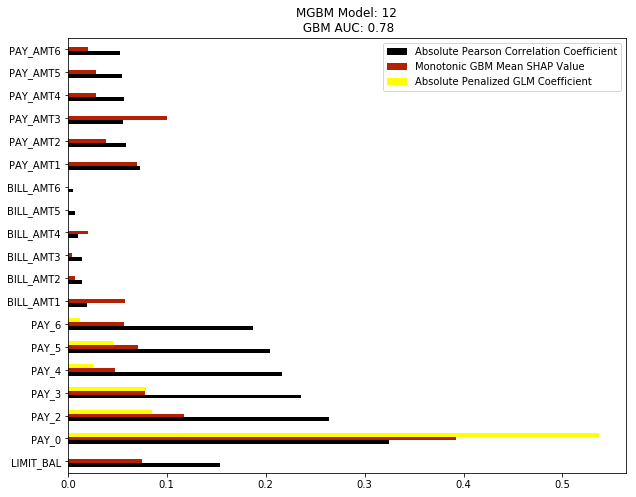

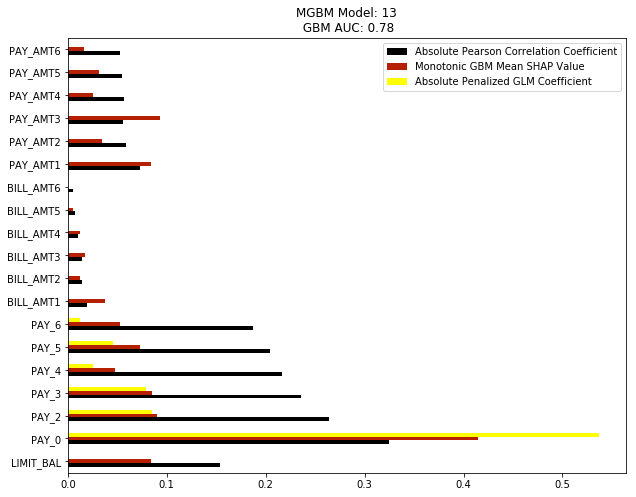

In [15]:
auto_ph.plot_coefs(corr_glm_mgbm_shap_coefs,
                   mgbm_models, 
                   'MGBM',
                   ['Absolute Pearson Correlation Coefficient',
                    'Monotonic GBM Mean SHAP Value',
                    'Absolute Penalized GLM Coefficient'])

#### Perform cross-validated ranking to select best MGBM

In [16]:
# autoph cv_model_rank_select function
# requires models to have model_id 
best_glm.model_id = 'best_glm'
compare_model_ids = ['best_glm'] # list of model_ids

# start local timer
tic = time.time()

# perform CV rank model selection
best_mgbm, mgbm_selected_coefs, best_mgbm_eval = auto_ph.cv_model_rank_select(valid,
                                                                              SEED,
                                                                              corr_glm_mgbm_shap_coefs, 
                                                                              mgbm_models, 
                                                                              'mgbm',
                                                                              compare_model_ids)

# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

Evaluated model 1/13 with rank: 1.20* ...
Evaluated model 2/13 with rank: 1.08* ...
Evaluated model 3/13 with rank: 1.08 ...
Evaluated model 4/13 with rank: 1.04* ...
Evaluated model 5/13 with rank: 1.00* ...
Evaluated model 6/13 with rank: 1.00 ...
Evaluated model 7/13 with rank: 1.04 ...
Evaluated model 8/13 with rank: 1.06 ...
Evaluated model 9/13 with rank: 1.08 ...
Evaluated model 10/13 with rank: 1.04 ...
Evaluated model 11/13 with rank: 1.04 ...
Evaluated model 12/13 with rank: 1.04 ...
Evaluated model 13/13 with rank: 1.04 ...
Done.
Task completed in 321.13 s.


#### Inspect best MGBM 

In [17]:
best_mgbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  mgbm5


Model Summary: 

number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               46.0                      46.0               6940.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        3.0        3.0         3.0         5.0         8.0     7.369565



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13637719864300343
RMSE: 0.3692928358945018
LogLoss: 0.4351274080189972
Mean Per-Class Error: 0.2913939696264273
AUC: 0.7716491282246187
pr_auc: 0.5471826859054356
Gini: 0.5432982564492375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21968260039166268: 

0       1   Error               Rate
0      0  13482.0  2814.0  0.1727   (2814.0/16296.0)
1      1   1907.0  2743.0  0.4101    (1907.0/4650.0)
2  Total  15389.0  5557.0  0.2254   (4721.0/20946.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold     value    idx
0                       max f1   0.219683  0.537474  248.0
1                       max f2   0.127859  0.630227  329.0
2                 max f0point5   0.446699  0.583033  147.0
3                 max accuracy   0.446699  0.821493  147.0
4                max precision   0.950247  1.000000    0.0
5                   max recall   0.050609  1.000000  395.0
6              max specificity   0.950247  1.000000    0.0
7             max absolute_mcc   0.325159  0.413494  194.0
8   max min_per_class_accuracy   0.177542  0.698495  281.0
9  max mean_per_class_accuracy   0.219683  0.708606  248.0


Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.00 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010074         0.813927  3.607883   
1         2                  0.020338         0.795575  3.519808   
2         3                  0.030316         0.763679  3.405328   
3         4                  0.040008         0.715138  3.261891   
4         5                  0.050081         0.664416  3.116869   
5         6                  0.100019         0.543384  2.859463   
6         7                  0.150005         0.366237  2.224293   
7         8                  0.205672         0.292765  1.595510   
8         9                  0.301251         0.196648  1.174504   
9        10                  0.400029         0.173817  0.864327   
10       11                  0.500286         0.151431  0.701418   
11       12                  0.600306         0.131214  0.619237   
12       13                  0.700659         0.114794  0.559314   
13       14                  0.800821         0.102226  0.369293   
14       15                  0.904564         0.091861  0.402152   
15       16                  1.000000         0.034810  0.241112   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.607883       0.800948  0.843446                  0.800948   
1          3.563432       0.781395  0.805153                  0.791080   
2          3.511394       0.755981  0.783970                  0.779528   
3          3.450954       0.724138  0.739815                  0.766110   
4          3.383755       0.691943  0.686695                  0.751192   
5          3.121984       0.634799  0.601794                  0.693079   
6          2.822849       0.493792  0.446951                  0.626671   
7          2.490659       0.354202  0.312777                  0.552925   
8          2.073077       0.260739  0.234499                  0.460222   
9          1.774604       0.191880  0.184844                  0.393961   
10         1.559537       0.155714  0.161335                  0.346216   
11         1.402870       0.137470  0.140709                  0.311436   
12         1.282050       0.124167  0.122817                  0.284614   
13         1.167887       0.081983  0.108062                  0.259270   
14         1.080066       0.089277  0.097524                  0.239774   
15         1.000000       0.053527  0.076989                  0.221999   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.843446      0.036344                 0.036344  260.788259   
1           0.824119      0.036129                 0.072473  251.980795   
2           0.810905      0.033978                 0.106452  240.532798   
3           0.793684      0.031613                 0.138065  226.189099   
4           0.772164      0.031398                 0.169462  211.686898   
5           0.687101      0.142796                 0.312258  185.946339   
6           0.607076      0.111183                 0.423441  122.429306   
7           0.527422      0.088817                 0.512258   59.551043   
8           0.434485      0.112258                 0.624516   17.450421   
9           0.372842      0.085376                 0.709892  -13.567284   
10          0.330455      0.070323                 0.780215  -29.858249   
11          0.298841      0.061935                 0.842151  -38.076342   
12          0.273630      0.056129                 0.898280  -44.068568   
13          0.252921      0.036989                 0.935269  -63.070697   
14          0.235099      0.041720                 0.976989  -59.784808   
15          0.220010      0.023011                 1.000000  -75.888783   

    cumulative_gain  
0        260.788259  
1        256.343177  
2        251.139446  
3        245.095388  
4        238.375473  
5        212.198445  
6        182.284922  
7        149.065864  
8        107.307684  
9         77.460410  
10        55.953665  
11        40.286982  
12        28.204987  
13    



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13326994104124376
RMSE: 0.3650615578792757
LogLoss: 0.4278285715046422
Mean Per-Class Error: 0.2856607030196092
AUC: 0.7776380047998697
pr_auc: 0.5486322626112021
Gini: 0.5552760095997393

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27397344199105433: 

0       1   Error              Rate
0      0  6093.0   975.0  0.1379    (975.0/7068.0)
1      1   863.0  1123.0  0.4345    (863.0/1986.0)
2  Total  6956.0  2098.0   0.203   (1838.0/9054.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold     value    idx
0                       max f1   0.273973  0.549951  217.0
1                       max f2   0.147835  0.634488  307.0
2                 max f0point5   0.436620  0.590736  153.0
3                 max accuracy   0.456963  0.825271  147.0
4                max precision   0.947069  1.000000    0.0
5                   max recall   0.045106  1.000000  397.0
6              max specificity   0.947069  1.000000    0.0
7             max absolute_mcc   0.347246  0.429999  184.0
8   max min_per_class_accuracy   0.181585  0.709970  275.0
9  max mean_per_class_accuracy   0.230518  0.714339  240.0


Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.52 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.011155         0.815010  3.295055   
1         2                  0.020543         0.795575  3.700764   
2         3                  0.030042         0.783550  3.604721   
3         4                  0.040093         0.743192  3.005876   
4         5                  0.050033         0.697702  3.444512   
5         6                  0.101281         0.553193  3.104777   
6         7                  0.150320         0.383564  2.187046   
7         8                  0.200022         0.296915  1.580423   
8         9                  0.301303         0.203539  1.133514   
9        10                  0.403468         0.176970  0.961068   
10       11                  0.500221         0.152028  0.655734   
11       12                  0.599956         0.133009  0.555349   
12       13                  0.702231         0.115062  0.492323   
13       14                  0.801966         0.102380  0.353404   
14       15                  0.905346         0.091861  0.379909   
15       16                  1.000000         0.034810  0.297899   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.295055       0.722772  0.839858                  0.722772   
1          3.480460       0.811765  0.805631                  0.763441   
2          3.519749       0.790698  0.792441                  0.772059   
3          3.390927       0.659341  0.761335                  0.743802   
4          3.401573       0.755556  0.723091                  0.746137   
5          3.251394       0.681034  0.614736                  0.713195   
6          2.904171       0.479730  0.466067                  0.637032   
7          2.575244       0.346667  0.327817                  0.564881   
8          2.090616       0.248637  0.250648                  0.458578   
9          1.804595       0.210811  0.187190                  0.395839   
10         1.582382       0.143836  0.163566                  0.347096   
11         1.411651       0.121816  0.141651                  0.309647   
12         1.277757       0.107991  0.123549                  0.280277   
13         1.162802       0.077519  0.107834                  0.255061   
14         1.073405       0.083333  0.097585                  0.235452   
15         1.000000       0.065344  0.076884                  0.219351   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.839858      0.036757                 0.036757  229.505549   
1           0.824217      0.034743                 0.071501  270.076417   
2           0.814170      0.034240                 0.105740  260.472142   
3           0.800925      0.030211                 0.135952  200.587630   
4           0.785461      0.034240                 0.170191  244.451158   
5           0.699075      0.159114                 0.329305  210.477654   
6           0.623061      0.107251                 0.436556  118.704581   
7           0.549698      0.078550                 0.515106   58.042296   
8           0.449174      0.114804                 0.629909   13.351366   
9           0.382836      0.098187                 0.728097   -3.893198   
10          0.340424      0.063444                 0.791541  -34.426603   
11          0.307381      0.055388                 0.846928  -44.465076   
12          0.280607      0.050352                 0.897281  -50.767685   
13          0.259121      0.035247                 0.932528  -64.659594   
14          0.240675      0.039275                 0.971803  -62.009063   
15          0.225172      0.028197                 1.000000  -70.210141   

    cumulative_gain  
0        229.505549  
1        248.045999  
2        251.974853  
3        239.092657  
4        240.157260  
5        225.139444  
6        190.417123  
7        157.524427  
8        109.061561  
9         80.459549  
10        58.238248  
11        41.165144  
12        27.775745  
13    



Scoring History: 

timestamp    duration  number_of_trees  training_rmse  \
0     2020-04-22 13:26:16  44.409 sec              0.0       0.415591   
1     2020-04-22 13:26:16  44.441 sec              1.0       0.407822   
2     2020-04-22 13:26:16  44.467 sec              2.0       0.401483   
3     2020-04-22 13:26:16  44.496 sec              3.0       0.396471   
4     2020-04-22 13:26:16  44.521 sec              4.0       0.392442   
5     2020-04-22 13:26:16  44.544 sec              5.0       0.389141   
6     2020-04-22 13:26:16  44.568 sec              6.0       0.386399   
7     2020-04-22 13:26:16  44.588 sec              7.0       0.384191   
8     2020-04-22 13:26:16  44.615 sec              8.0       0.382341   
9     2020-04-22 13:26:17  44.640 sec              9.0       0.380701   
10    2020-04-22 13:26:17  44.670 sec             10.0       0.379202   
11    2020-04-22 13:26:17  44.702 sec             11.0       0.378052   
12    2020-04-22 13:26:17  44.732 sec             12.0       0.377043   
13    2020-04-22 13:26:17  44.757 sec             13.0       0.376137   
14    2020-04-22 13:26:17  44.788 sec             14.0       0.375357   
15    2020-04-22 13:26:17  44.835 sec             15.0       0.374699   
16    2020-04-22 13:26:17  44.894 sec             16.0       0.374098   
17    2020-04-22 13:26:17  44.939 sec             17.0       0.373534   
18    2020-04-22 13:26:17  44.993 sec             18.0       0.373121   
19    2020-04-22 13:26:17  45.058 sec             19.0       0.372722   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.529427      0.500000         0.000000       1.000000   
1           0.511864      0.716131         0.534717       3.474912   
2           0.498746      0.744646         0.532172       3.529706   
3           0.489013      0.748189         0.535621       3.529706   
4           0.481430      0.750121         0.535358       3.529706   
5           0.475375      0.750058         0.535198       3.529706   
6           0.470332      0.756986         0.535024       3.529706   
7           0.466316      0.757005         0.535418       3.529706   
8           0.462760      0.761106         0.540176       3.514359   
9           0.459589      0.762515         0.540880       3.518279   
10          0.456705      0.762522         0.541424       3.518279   
11          0.454467      0.761648         0.541505       3.521332   
12          0.452420      0.762767         0.541658       3.521332   
13          0.450517      0.764795         0.543264       3.525899   
14          0.448963      0.765145         0.543113       3.525899   
15          0.447543      0.766118         0.544037       3.528417   
16          0.446341      0.766529         0.543896       3.560713   
17          0.445115      0.766312         0.544208       3.568370   
18          0.444171      0.766785         0.544720       3.568370   
19          0.443360      0.767145         0.545059       3.568370   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.778001         0.413815            0.526105   
1                        0.236370         0.405538            0.507496   
2                        0.228731         0.398808            0.493698   
3                        0.228636         0.393394            0.483273   
4                        0.210780         0.389030            0.475135   
5                        0.245059         0.385453            0.468630   
6                        0.243961         0.382447            0.463157   
7                        0.243961         0.380045            0.458834   
8                        0.247446         0.378063            0.455049   
9                        0.235654         0.376184            0.451464   
10                       0.235606         0.374583            0.448380   
11                       0.231023         0.373354            0.445973   
12                       0.229972         0.37219


See the whole table with table.as_data_frame()

Variable Importances: 

variable  relative_importance  scaled_importance  percentage
0      PAY_0          2794.444824           1.000000    0.693347
1      PAY_2           307.237366           0.109946    0.076231
2      PAY_3           215.152893           0.076993    0.053383
3      PAY_4           155.434448           0.055623    0.038566
4   PAY_AMT1           127.986313           0.045800    0.031755
5      PAY_5           127.538628           0.045640    0.031644
6      PAY_6           102.351601           0.036627    0.025395
7  LIMIT_BAL            82.432350           0.029499    0.020453
8   PAY_AMT2            58.934135           0.021090    0.014623
9   PAY_AMT4            58.858047           0.021063    0.014604

#### Assess best MGBM ranking

In [18]:
best_mgbm_eval

Fold    Metric  best_glm Value  mgbm5 Value  best_glm Rank  mgbm5 Rank
0     0        F1        0.533181     0.551298            2.0         1.0
1     0  accuracy        0.816246     0.817367            2.0         1.0
2     0       auc        0.738625     0.776026            2.0         1.0
3     0   logloss        0.468678     0.440775            2.0         1.0
4     0       mcc        0.419924     0.420105            2.0         1.0
5     1        F1        0.540865     0.554762            2.0         1.0
6     1  accuracy        0.823882     0.826063            2.0         1.0
7     1       auc        0.729674     0.776877            2.0         1.0
8     1   logloss        0.465999     0.434170            2.0         1.0
9     1       mcc        0.432722     0.445354            2.0         1.0
10    2        F1        0.500593     0.516364            2.0         1.0
11    2  accuracy        0.830907     0.833707            2.0         1.0
12    2       auc        0.707507     0.760838            2.0         1.0
13    2   logloss        0.459017     0.420930            2.0         1.0
14    2       mcc        0.395476     0.409254            2.0         1.0
15    3        F1        0.531328     0.550251            2.0         1.0
16    3  accuracy        0.834578     0.836713            2.0         1.0
17    3       auc        0.733536     0.782795            2.0         1.0
18    3   logloss        0.448512     0.416031            2.0         1.0
19    3       mcc        0.426465     0.443411            2.0         1.0
20    4        F1        0.561589     0.587666            2.0         1.0
21    4  accuracy        0.820845     0.829296            2.0         1.0
22    4       auc        0.740132     0.790550            2.0         1.0
23    4   logloss        0.467037     0.427654            2.0         1.0
24    4       mcc        0.448005     0.463860            2.0         1.0

#### Print mean rank for each model

In [19]:
print('Best GLM mean rank:', best_mgbm_eval['best_glm Rank'].mean())
print('Best MGBM mean rank:', best_mgbm_eval['mgbm5 Rank'].mean())

Best GLM mean rank: 2.0
Best MGBM mean rank: 1.0


#### Calculate partial dependence for each feature in best MGBM

In [20]:
# init dict to hold partial dependence and ICE values
# for each feature
# for mgbm
mgbm_pd_ice_dict = {}

# establish mgbm selected features
mgbm_selected = list(mgbm_selected_coefs[mgbm_selected_coefs['Monotonic GBM Mean SHAP Value'] != 0].index)

# calculate partial dependence for each selected feature
for xs in mgbm_selected: 
    mgbm_pd_ice_dict[xs] = auto_ph.pd_ice(xs, valid, best_mgbm)

#### Find some percentiles of yhat in the validation data
The values for `ID` that correspond to the maximum, minimum, and deciles of `p_DEFAULT_NEXT_MONTH` are displayed below. ICE will be calculated for the rows of the test dataset associated with these `ID` values.

In [21]:
# merge GBM predictions onto test data
mgbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             best_mgbm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                            axis=1)

# rename yhat column
mgbm_yhat_valid = mgbm_yhat_valid.rename(columns={'p1':'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
mgbm_percentile_dict = auto_ph.get_percentile_dict('p_DEFAULT_NEXT_MONTH', mgbm_yhat_valid, 'ID')

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
mgbm_percentile_dict

{0: 6593,
 99: 17863,
 10: 23504,
 20: 15919,
 30: 1919,
 40: 22205,
 50: 12297,
 60: 1847,
 70: 12644,
 80: 29479,
 90: 7682}

#### Calculate ICE curve values
ICE values represent a model's prediction for a row of data while an input variable of interest is varied across its domain. The values of the input variable are chosen to match the values at which partial dependence was calculated earlier, and ICE is calculated for the top three most important variables and for rows at each percentile of the test dataset. 

In [22]:
# loop through selected variables
for xs in mgbm_selected: 

    # collect bins used in partial dependence
    bins = list(mgbm_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(mgbm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        mgbm_pd_ice_dict[xs][col_name] = auto_ph.pd_ice(xs, 
                                                        valid[valid['ID'] == int(mgbm_percentile_dict[i])][mgbm_selected], 
                                                        best_mgbm, 
                                                        bins=bins)['partial_dependence']
       

#### Assess partial dependence and ICE for each feature in best GBM

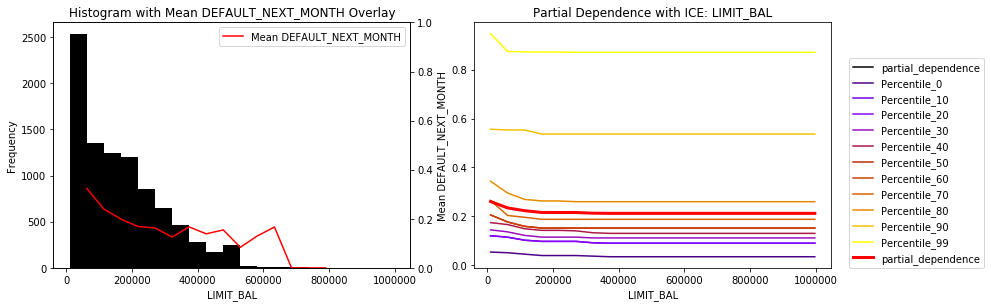

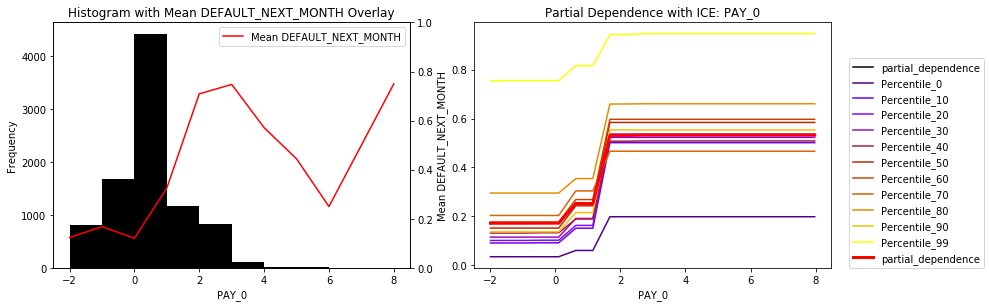

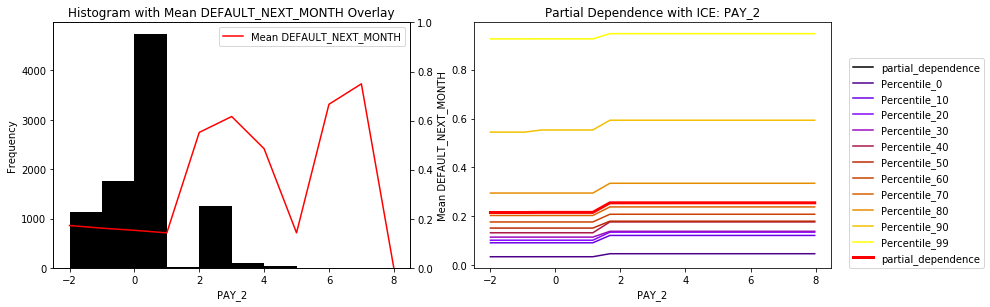

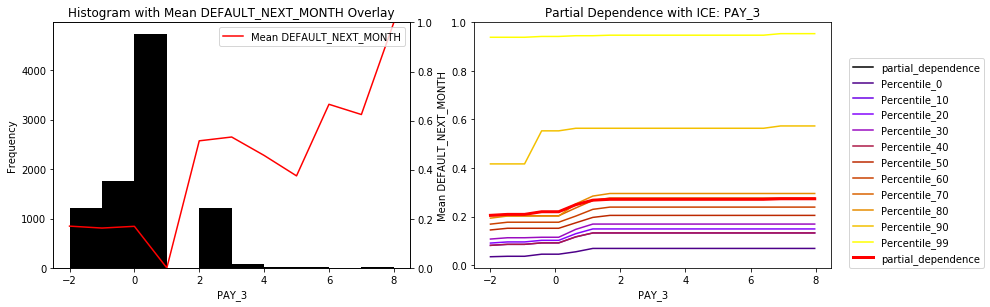

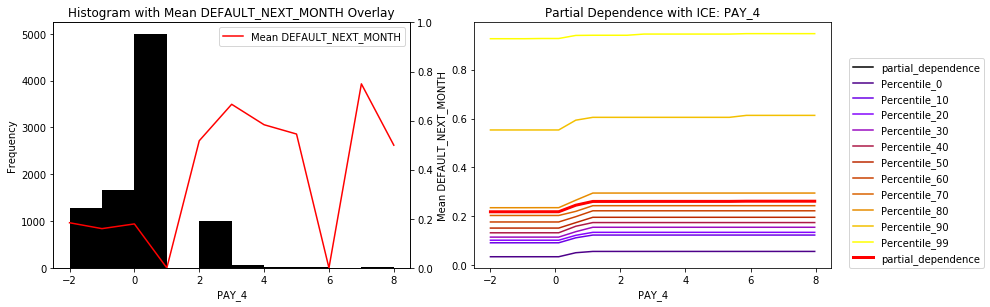

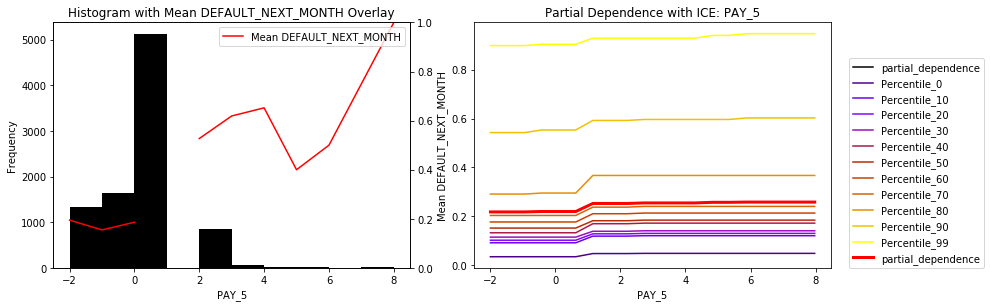

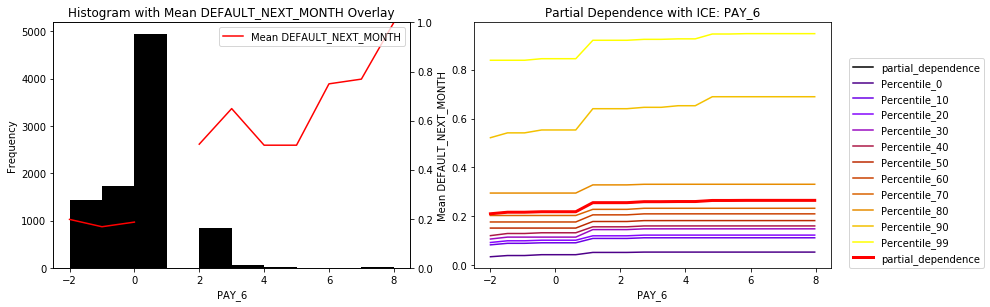

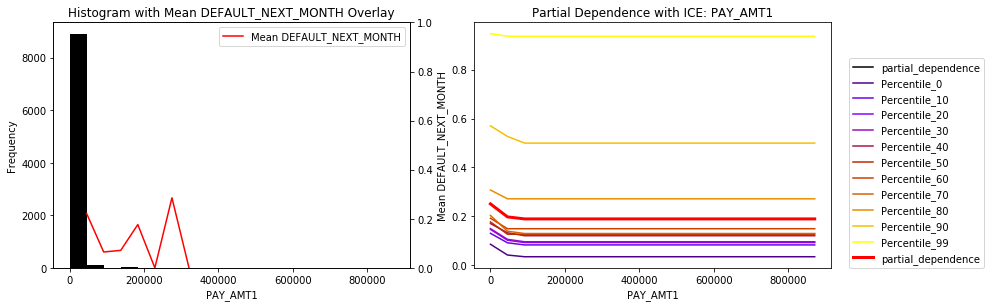

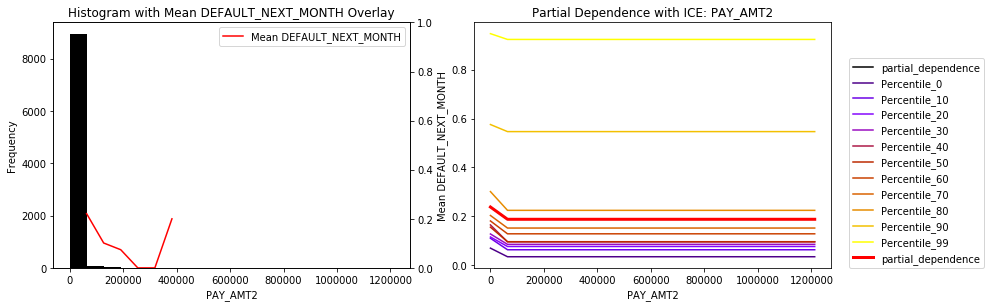

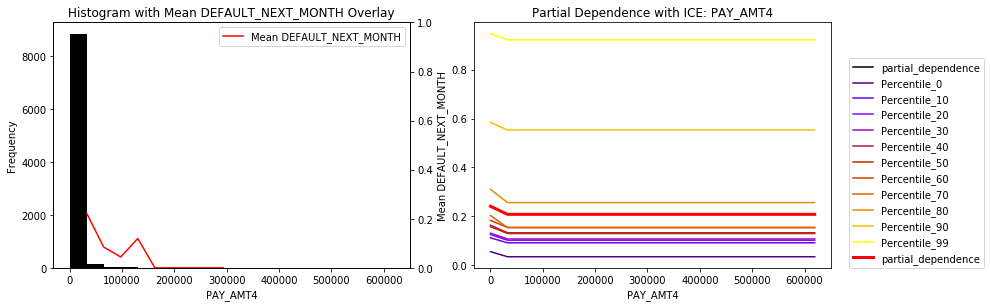

In [23]:
for xs in mgbm_selected: 
    auto_ph.hist_mean_pd_ice_plot(xs, y_name, valid, mgbm_pd_ice_dict)

## 5. Train GBMs with Forward Feature Selection

#### Forward step-wise training

In [24]:
# create a DataFrame to store new GBM SHAP values
# for comparison to correlation, penalized gbm, and mgbm coefficients
abs_corr_glm_mgbm_gbm_shap = abs_corr_glm_mgbm_shap.copy(deep=True)
abs_corr_glm_mgbm_gbm_shap['GBM Mean SHAP Value'] = 0

# start local timer
tic = time.time()

# stepwise GBM training
gbm_models, corr_glm_mgbm_gbm_shap_coefs = auto_ph.gbm_forward_select_train(glm_selected, 
                                                                            y_name, 
                                                                            train, 
                                                                            valid, 
                                                                            SEED, 
                                                                            next_list,
                                                                            abs_corr_glm_mgbm_gbm_shap, 
                                                                            'GBM Mean SHAP Value')

# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

Completed grid search 1/13 with AUC: 0.76 ...
Completed grid search 2/13 with AUC: 0.77 ...
Completed grid search 3/13 with AUC: 0.78 ...
Completed grid search 4/13 with AUC: 0.78 ...
Completed grid search 5/13 with AUC: 0.78 ...
Completed grid search 6/13 with AUC: 0.78 ...
Completed grid search 7/13 with AUC: 0.78 ...
Completed grid search 8/13 with AUC: 0.78 ...
Completed grid search 9/13 with AUC: 0.79 ...
Completed grid search 10/13 with AUC: 0.79 ...
Completed grid search 11/13 with AUC: 0.79 ...
Completed grid search 12/13 with AUC: 0.79 ...
Completed grid search 13/13 with AUC: 0.79 ...
Done.
Task completed in 628.57 s.


#### Compare new model feature importance to previous models

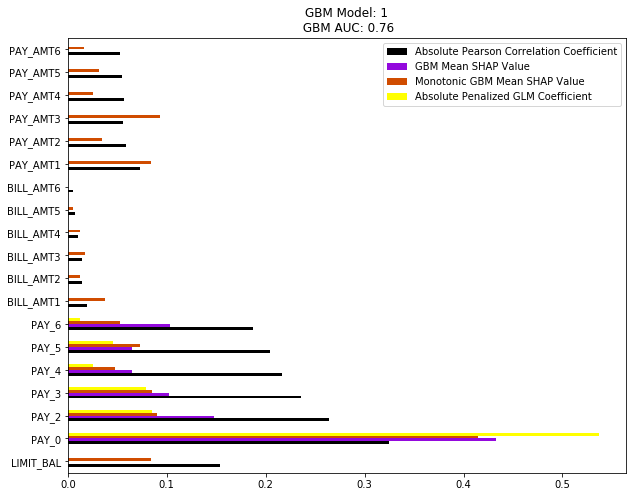

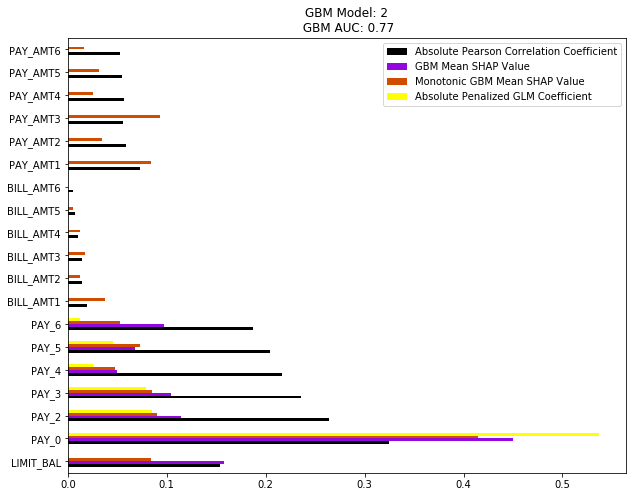

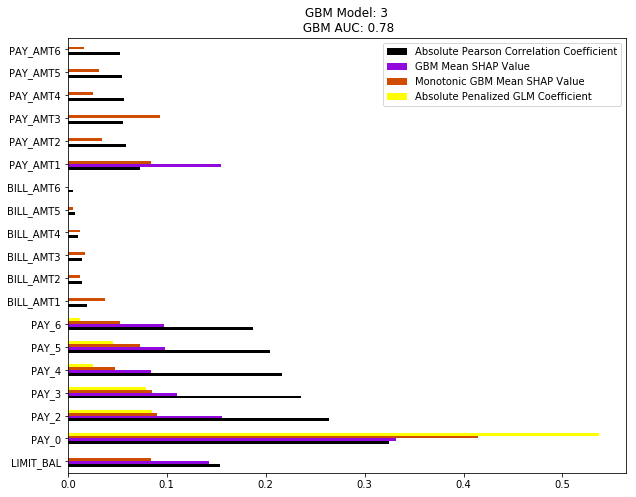

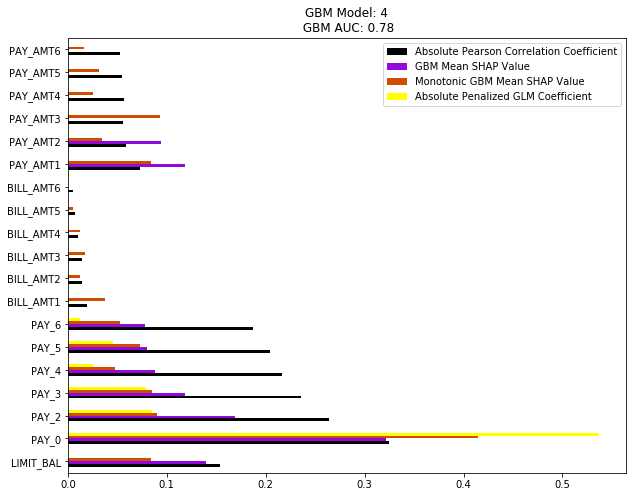

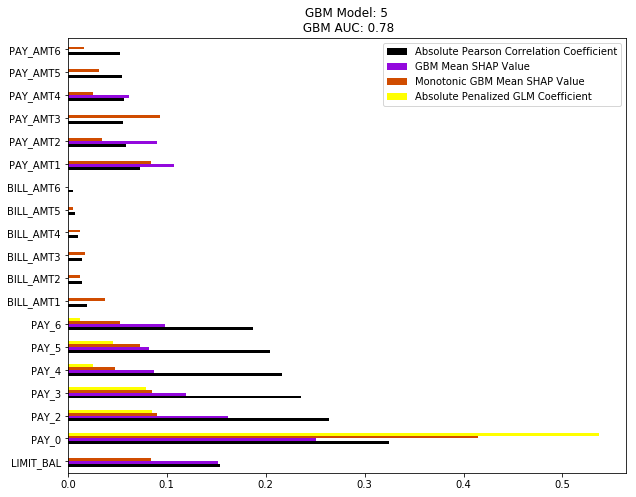

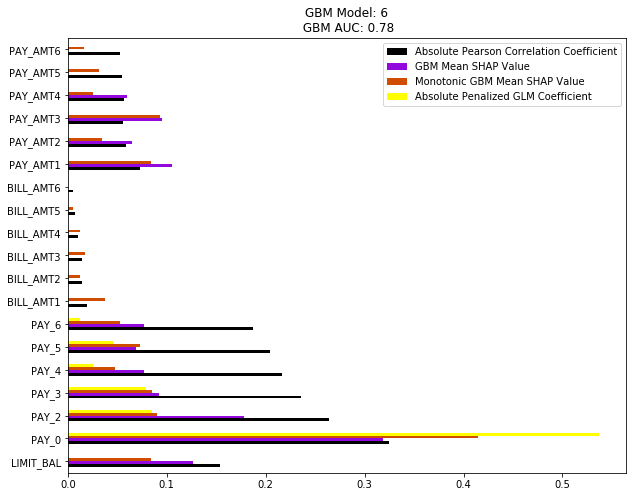

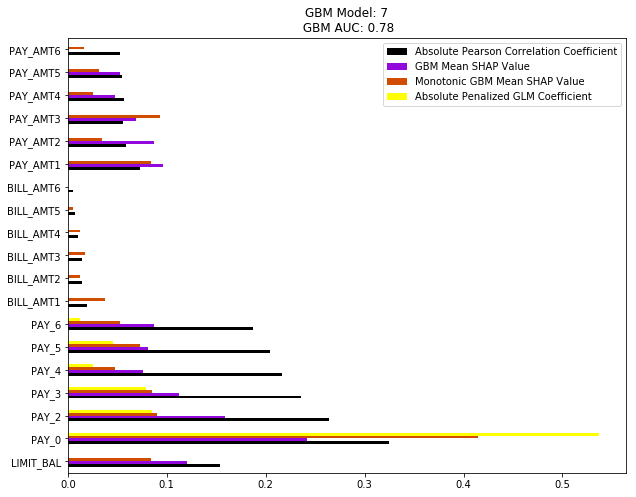

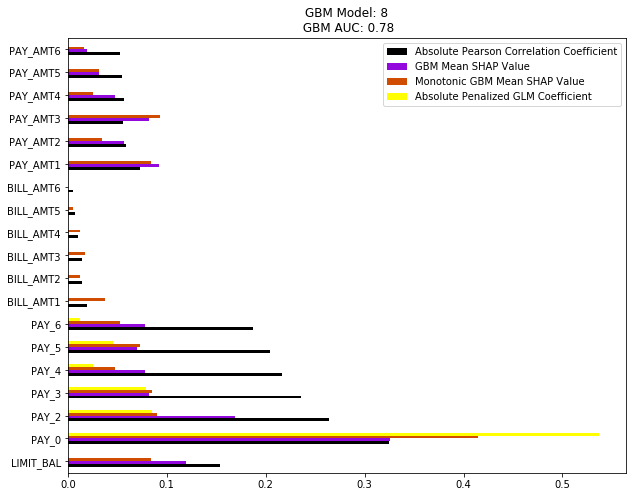

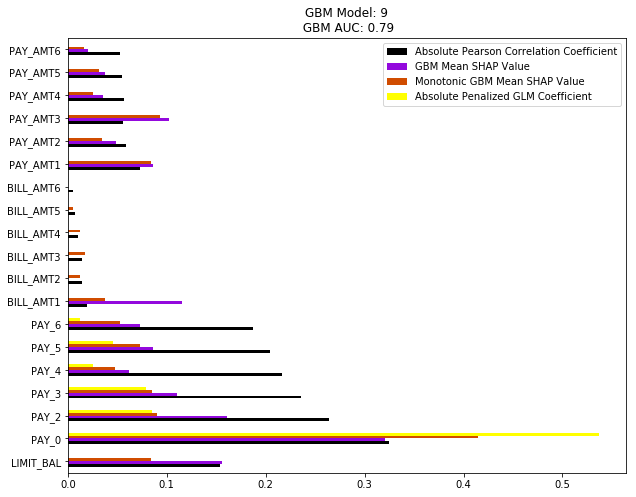

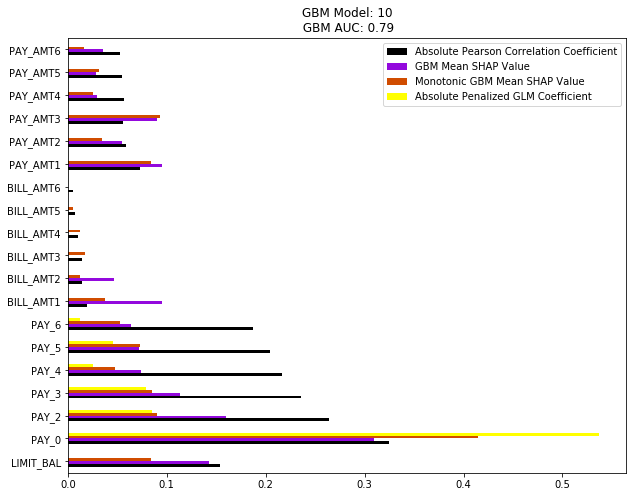

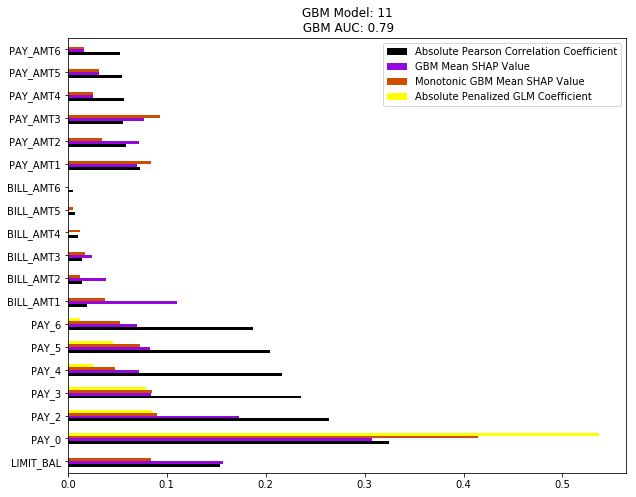

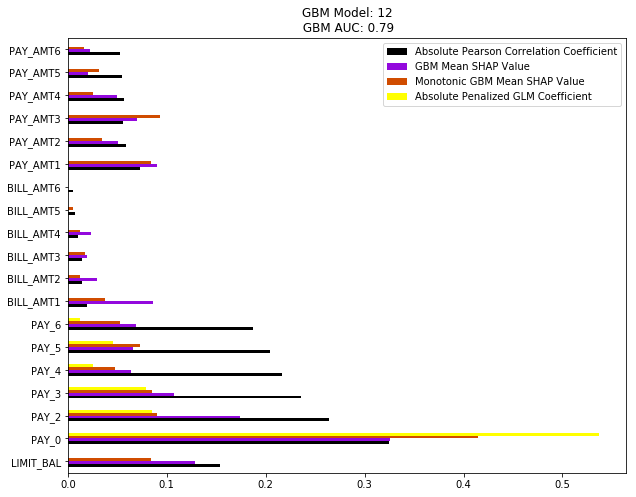

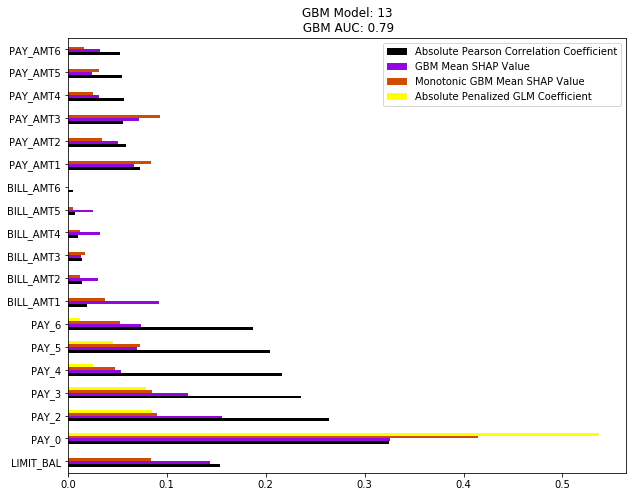

In [25]:
auto_ph.plot_coefs(corr_glm_mgbm_gbm_shap_coefs,
                   gbm_models, 
                   'GBM',
                   ['Absolute Pearson Correlation Coefficient',
                    'GBM Mean SHAP Value',
                    'Monotonic GBM Mean SHAP Value',
                    'Absolute Penalized GLM Coefficient'])

#### Perform cross-validated ranking to select best GBM

In [26]:
# autoph cv_model_rank_select function
# requires models to have model_id 
best_mgbm.model_id = 'best_mgbm'
compare_model_ids = ['best_glm', 'best_mgbm']

# start local timer
tic = time.time()

# perform CV rank model selection
best_gbm, gbm_selected_coefs, best_gbm_eval = auto_ph.cv_model_rank_select(valid,
                                                                           SEED,
                                                                           corr_glm_mgbm_gbm_shap_coefs, 
                                                                           gbm_models, 
                                                                           'gbm',
                                                                           compare_model_ids)

# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

Evaluated model 1/13 with rank: 1.94* ...
Evaluated model 2/13 with rank: 1.54* ...
Evaluated model 3/13 with rank: 1.44* ...
Evaluated model 4/13 with rank: 1.36* ...
Evaluated model 5/13 with rank: 1.48 ...
Evaluated model 6/13 with rank: 1.38 ...
Evaluated model 7/13 with rank: 1.50 ...
Evaluated model 8/13 with rank: 1.30* ...
Evaluated model 9/13 with rank: 1.20* ...
Evaluated model 10/13 with rank: 1.20 ...
Evaluated model 11/13 with rank: 1.16* ...
Evaluated model 12/13 with rank: 1.32 ...
Evaluated model 13/13 with rank: 1.26 ...
Done.
Task completed in 699.37 s.


#### Inspect best GBM 

In [27]:
best_gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm11


Model Summary: 

number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               44.0                      44.0              17851.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        5.0        5.0         5.0        19.0        32.0    27.568182



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1297424233125429
RMSE: 0.3601977558405145
LogLoss: 0.41569809892760357
Mean Per-Class Error: 0.27659833404595624
AUC: 0.7998092479980574
pr_auc: 0.6005338055620879
Gini: 0.5996184959961148

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2649121913379078: 

0       1   Error               Rate
0      0  14006.0  2290.0  0.1405   (2290.0/16296.0)
1      1   1954.0  2696.0  0.4202    (1954.0/4650.0)
2  Total  15960.0  4986.0  0.2026   (4244.0/20946.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold     value    idx
0                       max f1   0.264912  0.559568  219.0
1                       max f2   0.127389  0.651895  320.0
2                 max f0point5   0.440340  0.599546  147.0
3                 max accuracy   0.565283  0.825886  107.0
4                max precision   0.906543  1.000000    0.0
5                   max recall   0.045607  1.000000  394.0
6              max specificity   0.906543  1.000000    0.0
7             max absolute_mcc   0.367664  0.439748  175.0
8   max min_per_class_accuracy   0.183067  0.714839  273.0
9  max mean_per_class_accuracy   0.219738  0.723402  246.0


Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.24 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010026         0.806812  4.225665   
1         2                  0.020004         0.772695  3.857935   
2         3                  0.030030         0.746236  3.775214   
3         4                  0.040008         0.722744  3.707066   
4         5                  0.050033         0.697132  3.346212   
5         6                  0.100019         0.564983  2.878244   
6         7                  0.150005         0.397339  2.103828   
7         8                  0.200038         0.314363  1.732176   
8         9                  0.300057         0.219055  1.225572   
9        10                  0.400029         0.175054  0.873368   
10       11                  0.500000         0.147656  0.748602   
11       12                  0.600019         0.127317  0.636438   
12       13                  0.699990         0.108453  0.509823   
13       14                  0.800010         0.092868  0.412824   
14       15                  0.899981         0.073586  0.217267   
15       16                  1.000000         0.030757  0.126857   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          4.225665       0.938095  0.834493                  0.938095   
1          4.042239       0.856459  0.787884                  0.897375   
2          3.953089       0.838095  0.760955                  0.877583   
3          3.891730       0.822967  0.733924                  0.863962   
4          3.782418       0.742857  0.709277                  0.839695   
5          3.330547       0.638968  0.630202                  0.739379   
6          2.921771       0.467049  0.477395                  0.648631   
7          2.624230       0.384542  0.352826                  0.582578   
8          2.158011       0.272076  0.256601                  0.479077   
9          1.836965       0.193887  0.195199                  0.407805   
10         1.619355       0.166189  0.159996                  0.359496   
11         1.455509       0.141289  0.137817                  0.323122   
12         1.320448       0.113181  0.117489                  0.293139   
13         1.206975       0.091647  0.100889                  0.267948   
14         1.097036       0.048233  0.082605                  0.243541   
15         1.000000       0.028162  0.060595                  0.221999   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.834493      0.042366                 0.042366  322.566513   
1           0.811244      0.038495                 0.080860  285.793487   
2           0.794454      0.037849                 0.118710  277.521352   
3           0.779358      0.036989                 0.155699  270.706591   
4           0.765315      0.033548                 0.189247  234.621198   
5           0.697791      0.143871                 0.333118  187.824383   
6           0.624349      0.105161                 0.438280  110.382845   
7           0.556436      0.086667                 0.524946   73.217557   
8           0.456491      0.122581                 0.647527   22.557241   
9           0.391192      0.087312                 0.734839  -12.663154   
10          0.344966      0.074839                 0.809677  -25.139847   
11          0.310435      0.063656                 0.873333  -36.356240   
12          0.282879      0.050968                 0.924301  -49.017654   
13          0.260126      0.041290                 0.965591  -58.717561   
14          0.240407      0.021720                 0.987312  -78.273346   
15          0.222422      0.012688                 1.000000  -87.314251   

    cumulative_gain  
0        322.566513  
1        304.223882  
2        295.308888  
3        289.172993  
4        278.241812  
5        233.054677  
6        192.177081  
7        162.423004  
8        115.801083  
9         83.696522  
10        61.935484  
11        45.550923  
12        32.044812  
13    



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13197243166584371
RMSE: 0.3632801008393437
LogLoss: 0.4228548881641006
Mean Per-Class Error: 0.2799766019180101
AUC: 0.7859376487136042
pr_auc: 0.5604814720383086
Gini: 0.5718752974272083

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2836639879283261: 

0       1   Error              Rate
0      0  6087.0   981.0  0.1388    (981.0/7068.0)
1      1   841.0  1145.0  0.4235    (841.0/1986.0)
2  Total  6928.0  2126.0  0.2012   (1822.0/9054.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold     value    idx
0                       max f1   0.283664  0.556907  201.0
1                       max f2   0.136697  0.641801  303.0
2                 max f0point5   0.446778  0.591413  137.0
3                 max accuracy   0.454787  0.825050  134.0
4                max precision   0.883619  1.000000    0.0
5                   max recall   0.032253  1.000000  399.0
6              max specificity   0.883619  1.000000    0.0
7             max absolute_mcc   0.394464  0.432378  156.0
8   max min_per_class_accuracy   0.186254  0.711517  259.0
9  max mean_per_class_accuracy   0.270007  0.720023  207.0


Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.74 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010051         0.810161  3.707247   
1         2                  0.020102         0.779219  3.556954   
2         3                  0.030042         0.756505  3.596475   
3         4                  0.040093         0.737192  3.406660   
4         5                  0.050033         0.708051  3.241893   
5         6                  0.100066         0.580696  2.938637   
6         7                  0.149989         0.414005  2.339973   
7         8                  0.200353         0.322792  1.609616   
8         9                  0.299978         0.226130  1.223123   
9        10                  0.400044         0.178058  0.830266   
10       11                  0.500000         0.149613  0.735471   
11       12                  0.599956         0.128154  0.594422   
12       13                  0.700022         0.108786  0.483064   
13       14                  0.799978         0.092697  0.408035   
14       15                  0.899934         0.073773  0.312323   
15       16                  1.000000         0.030634  0.216372   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.707247       0.813187  0.835473                  0.813187   
1          3.632101       0.780220  0.795835                  0.796703   
2          3.620313       0.788889  0.769156                  0.794118   
3          3.566752       0.747253  0.746407                  0.782369   
4          3.502211       0.711111  0.722268                  0.768212   
5          3.220424       0.644592  0.641571                  0.706402   
6          2.927372       0.513274  0.499570                  0.642121   
7          2.596117       0.353070  0.368892                  0.569460   
8          2.140137       0.268293  0.266316                  0.469440   
9          1.812489       0.182119  0.201055                  0.397570   
10         1.597180       0.161326  0.162219                  0.350342   
11         1.430115       0.130387  0.139095                  0.313697   
12         1.294737       0.105960  0.118260                  0.284001   
13         1.183945       0.089503  0.101351                  0.259699   
14         1.087134       0.068508  0.082437                  0.238463   
15         1.000000       0.047461  0.060843                  0.219351   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.835473      0.037261                 0.037261  270.724744   
1           0.815654      0.035750                 0.073011  255.695362   
2           0.800269      0.035750                 0.108761  259.647533   
3           0.786766      0.034240                 0.143001  240.665981   
4           0.773952      0.032226                 0.175227  224.189325   
5           0.707762      0.147029                 0.322256  193.863668   
6           0.638467      0.116818                 0.439074  133.997273   
7           0.570701      0.081067                 0.520141   60.961600   
8           0.469613      0.121853                 0.641994   22.312284   
9           0.402437      0.083082                 0.725076  -16.973450   
10          0.354414      0.073515                 0.798590  -26.452905   
11          0.318541      0.059416                 0.858006  -40.557827   
12          0.289911      0.048338                 0.906344  -51.693644   
13          0.266351      0.040785                 0.947130  -59.196475   
14          0.245924      0.031219                 0.978348  -68.767672   
15          0.227403      0.021652                 1.000000  -78.362778   

    cumulative_gain  
0        270.724744  
1        263.210053  
2        262.031278  
3        256.675239  
4        250.221084  
5        222.042376  
6        192.737231  
7        159.611714  
8        114.013744  
9         81.248864  
10        59.718026  
11        43.011537  
12        29.473687  
13    



Scoring History: 

timestamp    duration  number_of_trees  training_rmse  \
0     2020-04-22 13:48:59  38.434 sec              0.0       0.415591   
1     2020-04-22 13:49:00  38.460 sec              1.0       0.408371   
2     2020-04-22 13:49:00  38.487 sec              2.0       0.402294   
3     2020-04-22 13:49:00  38.518 sec              3.0       0.398340   
4     2020-04-22 13:49:00  38.559 sec              4.0       0.394118   
5     2020-04-22 13:49:00  38.619 sec              5.0       0.390081   
6     2020-04-22 13:49:00  38.679 sec              6.0       0.385902   
7     2020-04-22 13:49:00  38.724 sec              7.0       0.382504   
8     2020-04-22 13:49:00  38.782 sec              8.0       0.379618   
9     2020-04-22 13:49:00  38.831 sec              9.0       0.377172   
10    2020-04-22 13:49:00  38.889 sec             10.0       0.375774   
11    2020-04-22 13:49:00  38.941 sec             11.0       0.374535   
12    2020-04-22 13:49:00  39.010 sec             12.0       0.372964   
13    2020-04-22 13:49:00  39.071 sec             13.0       0.371596   
14    2020-04-22 13:49:00  39.143 sec             14.0       0.370411   
15    2020-04-22 13:49:00  39.198 sec             15.0       0.369378   
16    2020-04-22 13:49:00  39.260 sec             16.0       0.368553   
17    2020-04-22 13:49:00  39.310 sec             17.0       0.367919   
18    2020-04-22 13:49:00  39.381 sec             18.0       0.367264   
19    2020-04-22 13:49:00  39.428 sec             19.0       0.366730   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.529427      0.500000         0.000000       1.000000   
1           0.513004      0.736348         0.508118       3.571084   
2           0.500237      0.756976         0.530464       3.660533   
3           0.492278      0.764069         0.532898       3.813125   
4           0.483784      0.768168         0.540150       3.845837   
5           0.475984      0.771084         0.543405       3.739598   
6           0.467950      0.776430         0.553219       3.816326   
7           0.461554      0.777344         0.557804       3.831896   
8           0.456175      0.778102         0.561744       3.906760   
9           0.451580      0.778836         0.564685       3.905203   
10          0.448747      0.780541         0.565119       3.849675   
11          0.446260      0.781854         0.566824       3.882464   
12          0.443330      0.782210         0.568613       3.915140   
13          0.440754      0.782722         0.570082       3.946814   
14          0.438517      0.783312         0.572051       4.011164   
15          0.436511      0.783760         0.573630       3.992154   
16          0.434903      0.783928         0.575126       4.054065   
17          0.433482      0.784829         0.576147       4.054065   
18          0.432128      0.785397         0.577299       4.033589   
19          0.430958      0.785965         0.578072       4.032614   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.778001         0.413815            0.526105   
1                        0.228397         0.406217            0.508920   
2                        0.221045         0.400137            0.496260   
3                        0.221808         0.396285            0.488590   
4                        0.220376         0.392061            0.480133   
5                        0.218610         0.388102            0.472546   
6                        0.213931         0.383888            0.464422   
7                        0.209634         0.380625            0.458223   
8                        0.210541         0.377821            0.453004   
9                        0.205910         0.375476            0.448572   
10                       0.200086         0.374165            0.445917   
11                       0.203428         0.373194            0.443968   
12                       0.202903         0.37161


See the whole table with table.as_data_frame()

Variable Importances: 

variable  relative_importance  scaled_importance  percentage
0       PAY_0          1327.677734           1.000000    0.298469
1       PAY_2           870.664368           0.655780    0.195730
2       PAY_5           385.968719           0.290710    0.086768
3       PAY_6           367.919647           0.277115    0.082710
4       PAY_4           271.276825           0.204324    0.060985
5   LIMIT_BAL           255.897079           0.192740    0.057527
6       PAY_3           237.898102           0.179184    0.053481
7   BILL_AMT1           139.980881           0.105433    0.031468
8    PAY_AMT1           129.845551           0.097799    0.029190
9   BILL_AMT2           110.725052           0.083398    0.024892
10   PAY_AMT3            90.709625           0.068322    0.020392
11   PAY_AMT2            84.566849           0.063695    0.019011
12  BILL_AMT3            52.510399           0.039551    0.011805
13   PAY_AMT5            50.029984           0.037682    0.011247
14   PAY_AMT4            42.780476           0.032222    0.009617
15   PAY_AMT6            29.835304           0.022472    0.006707

#### Assess best GBM ranking

In [28]:
best_gbm_eval

Fold    Metric  best_glm Value  best_mgbm Value  gbm11 Value  \
0     0        F1        0.533181         0.551298     0.562353   
1     0  accuracy        0.816246         0.817367     0.814006   
2     0       auc        0.738625         0.776026     0.777570   
3     0   logloss        0.468678         0.440775     0.438078   
4     0       mcc        0.419924         0.420105     0.426918   
5     1        F1        0.540865         0.554762     0.555283   
6     1  accuracy        0.823882         0.826063     0.828244   
7     1       auc        0.729674         0.776877     0.785956   
8     1   logloss        0.465999         0.434170     0.428677   
9     1       mcc        0.432722         0.445354     0.447637   
10    2        F1        0.500593         0.516364     0.530343   
11    2  accuracy        0.830907         0.833707     0.835946   
12    2       auc        0.707507         0.760838     0.769493   
13    2   logloss        0.459017         0.420930     0.417171   
14    2       mcc        0.395476         0.409254     0.411118   
15    3        F1        0.531328         0.550251     0.557500   
16    3  accuracy        0.834578         0.836713     0.835112   
17    3       auc        0.733536         0.782795     0.791644   
18    3   logloss        0.448512         0.416031     0.411094   
19    3       mcc        0.426465         0.443411     0.445759   
20    4        F1        0.561589         0.587666     0.593037   
21    4  accuracy        0.820845         0.829296     0.826479   
22    4       auc        0.740132         0.790550     0.803337   
23    4   logloss        0.467037         0.427654     0.419666   
24    4       mcc        0.448005         0.463860     0.472417   

    best_glm Rank  best_mgbm Rank  gbm11 Rank  
0             3.0             2.0         1.0  
1             2.0             1.0         3.0  
2             3.0             2.0         1.0  
3             3.0             2.0         1.0  
4             3.0             2.0         1.0  
5             3.0             2.0         1.0  
6             3.0             2.0         1.0  
7             3.0             2.0         1.0  
8             3.0             2.0         1.0  
9             3.0             2.0         1.0  
10            3.0             2.0         1.0  
11            3.0             2.0         1.0  
12            3.0             2.0         1.0  
13            3.0             2.0         1.0  
14            3.0             2.0         1.0  
15            3.0             2.0         1.0  
16            3.0             1.0         2.0  
17            3.0             2.0         1.0  
18            3.0             2.0         1.0  
19            3.0             2.0         1.0  
20            3.0             2.0         1.0  
21            3.0             1.0         2.0  
22            3.0             2.0         1.0  
23            3.0             2.0         1.0  
24            3.0             2.0         1.0

#### Print mean rank for each model

In [29]:
print('Best GLM mean rank:', best_gbm_eval['best_glm Rank'].mean())
print('Best MGBM mean rank:', best_gbm_eval['best_mgbm Rank'].mean())
print('Best GBM mean rank:', best_gbm_eval['gbm11 Rank'].mean())

Best GLM mean rank: 2.96
Best MGBM mean rank: 1.88
Best GBM mean rank: 1.16


#### Calculate partial dependence for each feature in best GBM

In [30]:
# init dict to hold partial dependence and ICE values
# for each feature
# for gbm
gbm_pd_ice_dict = {}

# establish gbm selected features
gbm_selected = list(gbm_selected_coefs[gbm_selected_coefs['GBM Mean SHAP Value'] != 0].index)

# calculate partial dependence for each selected feature
for xs in gbm_selected:
    gbm_pd_ice_dict[xs] = auto_ph.pd_ice(xs, valid, best_gbm)

#### Find some percentiles of yhat in the validation data

In [31]:
# merge GBM predictions onto test data
gbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                            best_gbm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                           axis=1)

# rename yhat column
gbm_yhat_valid = gbm_yhat_valid.rename(columns={'p1':'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
gbm_percentile_dict = auto_ph.get_percentile_dict('p_DEFAULT_NEXT_MONTH', gbm_yhat_valid, 'ID')

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
gbm_percentile_dict

{0: 983,
 99: 17757,
 10: 20120,
 20: 7828,
 30: 29363,
 40: 10128,
 50: 8305,
 60: 27620,
 70: 6546,
 80: 16855,
 90: 16995}

#### Calculate ICE curve values

In [32]:
# loop through selected variables
for xs in gbm_selected: 

    # collect bins used in partial dependence
    bins = list(gbm_pd_ice_dict[xs][xs])

    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature    
    for i in sorted(gbm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        gbm_pd_ice_dict[xs][col_name] = auto_ph.pd_ice(xs, 
                                                       valid[valid['ID'] == int(gbm_percentile_dict[i])][gbm_selected], 
                                                       best_gbm, 
                                                       bins=bins)['partial_dependence']
       

#### Assess partial dependence and ICE for each feature in best GBM

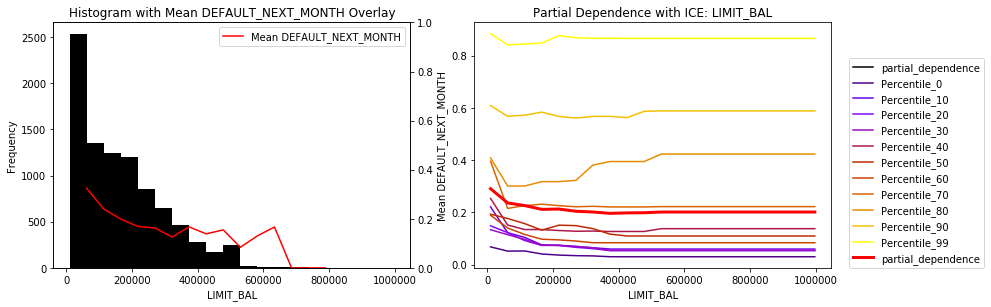

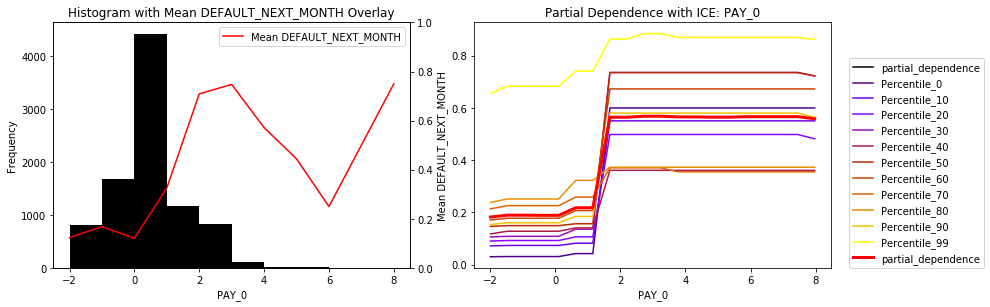

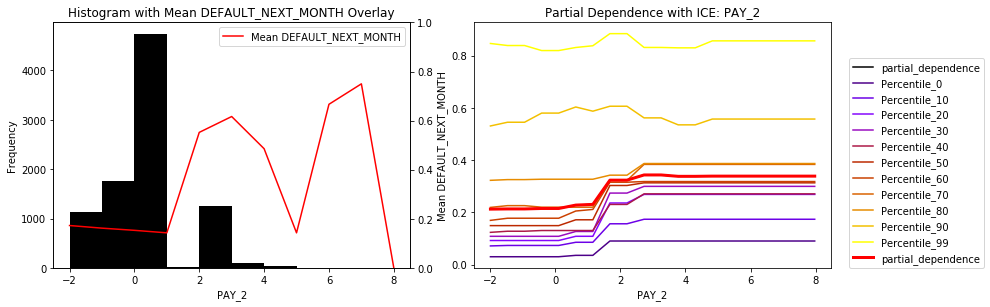

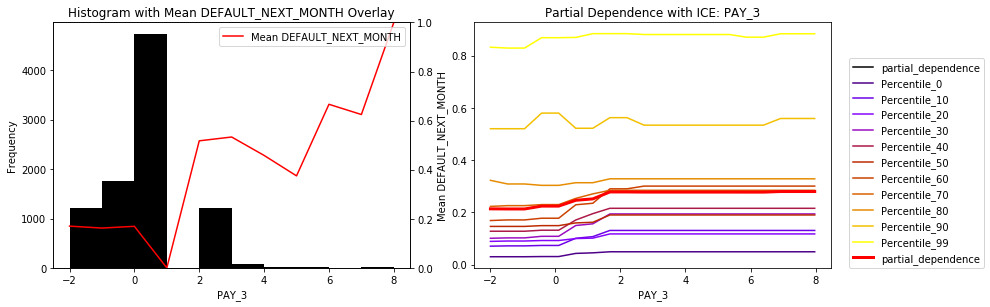

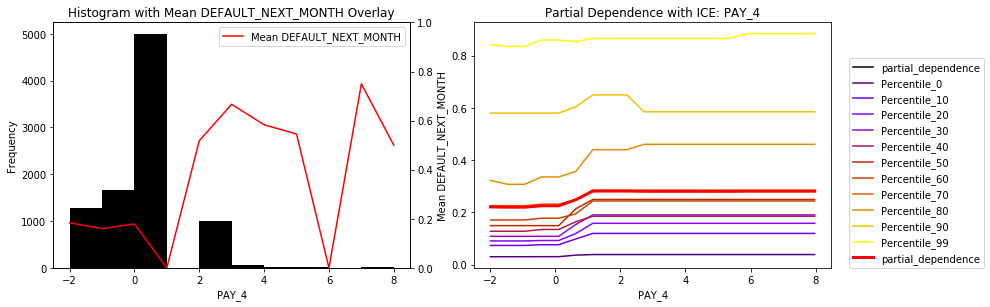

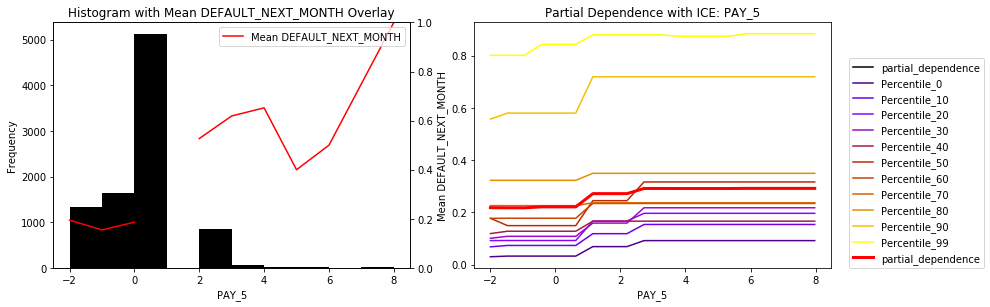

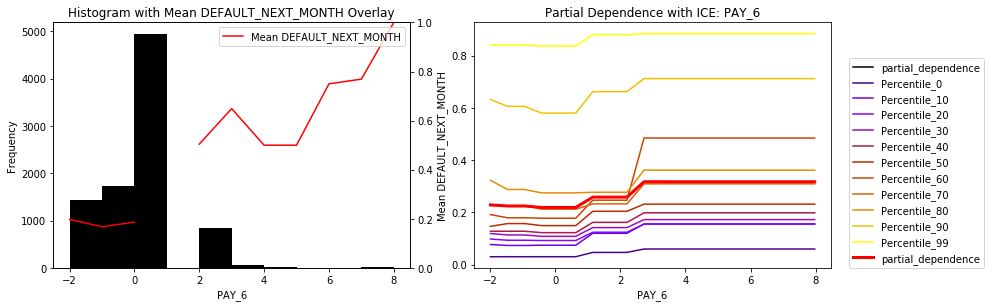

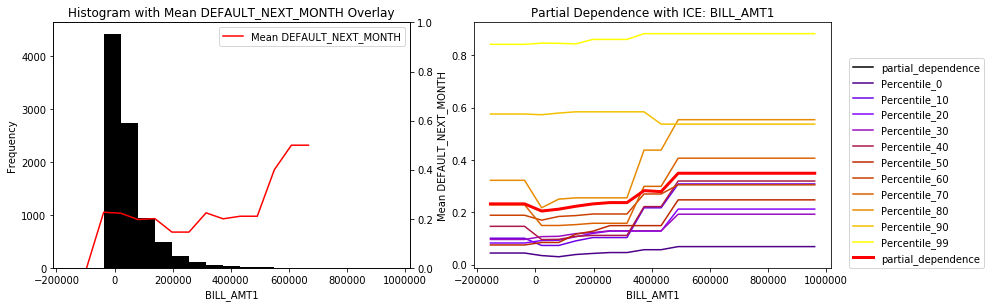

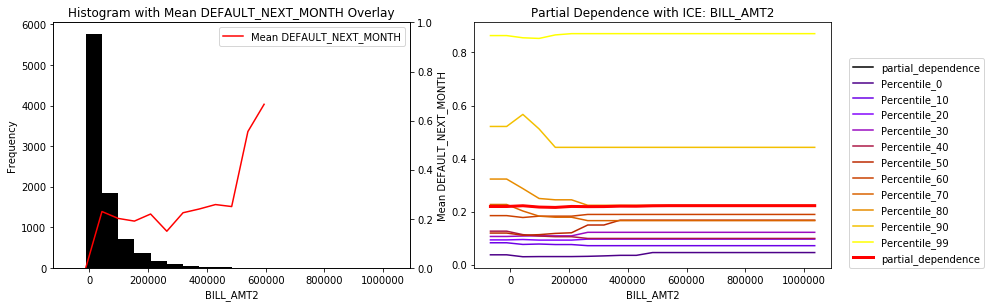

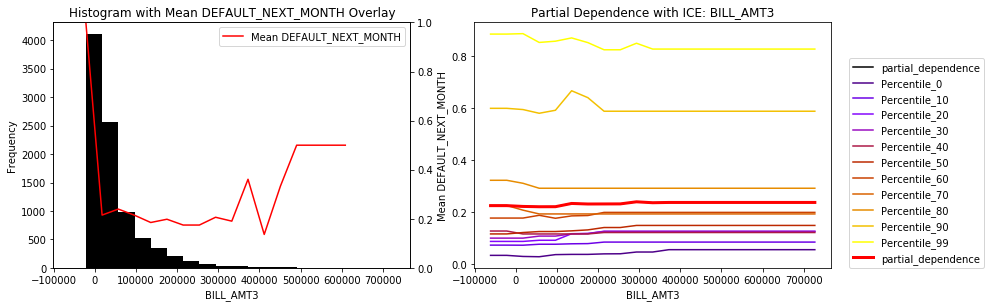

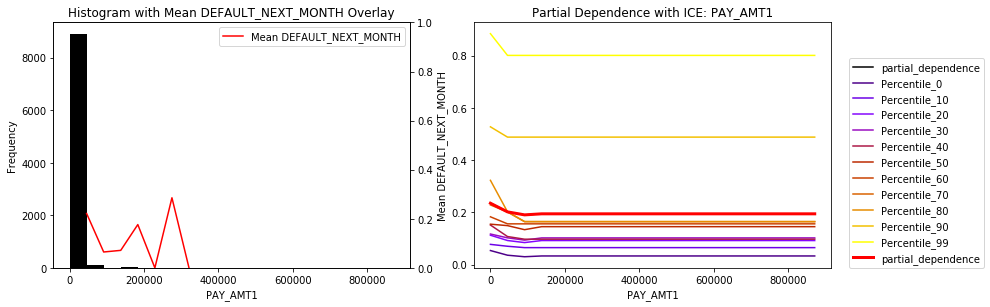

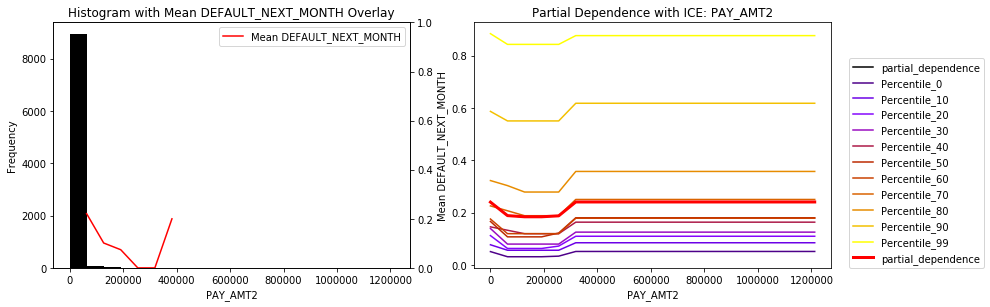

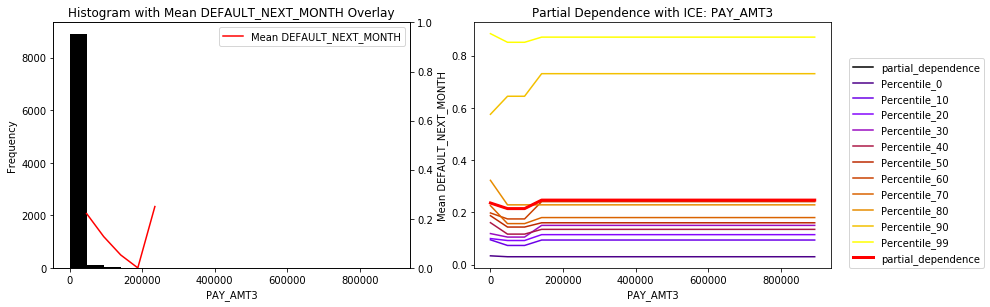

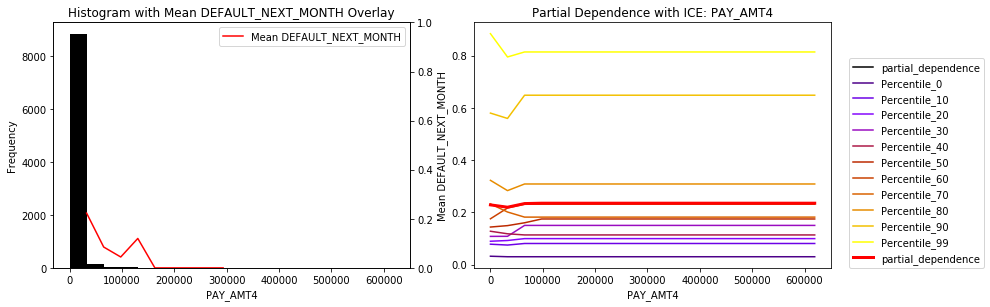

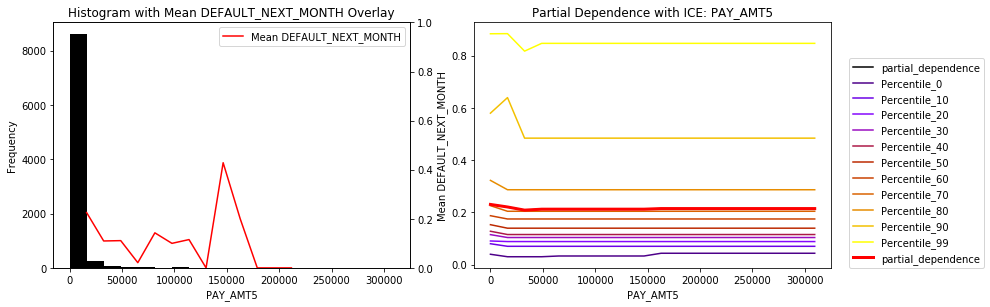

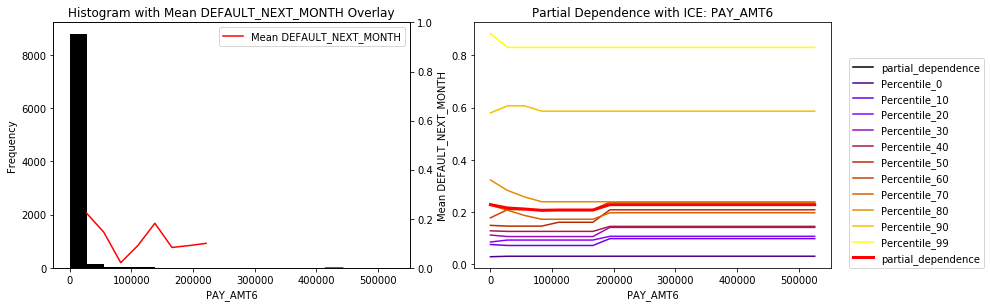

In [33]:
for xs in gbm_selected: 
    auto_ph.hist_mean_pd_ice_plot(xs, y_name, valid, gbm_pd_ice_dict)

## 6. Select Monotonicity Constraints Based on Previous Models

#### Use a heuristic rule to automatically select hybrid monotonicity constraints 

In [51]:
# retrain with learned monotonicity constraints
# use some threshold of ICE lines being monotonic to create new set of monotonicity contraints

# init data structures
# for automatically selected monotonicity constraints
hybrid_mono_dict = {}
ice_curve_names = None

# loop through features in GBM
for xs in gbm_pd_ice_dict.keys():
    
    # establish names for ICE curves 
    if ice_curve_names is None:
        ice_curve_names = [name for name in gbm_pd_ice_dict['PAY_0'].columns
                           if name.startswith('Percentile_')]
    
    
    # count the number of monotonic ICE curves for each feature
    count = 0 
    for name in ice_curve_names:
    
        if gbm_pd_ice_dict[xs][name].is_monotonic:
            count += 1

        elif gbm_pd_ice_dict[xs][name].is_monotonic_decreasing:
            count += 1

        else:
            pass

    # use global MONO_THRESHOLD hyperparameter
    # to decide whether a feature should be constrained 
    if count >= MONO_THRESHOLD: 
        hybrid_mono_dict[xs] = np.sign(valid[[xs] + [y_name]].corr()[y_name].values[:-1])[0]
    else: 
        hybrid_mono_dict[xs] = 0
        
# print selected monotone constraints        
print(hybrid_mono_dict)

{'LIMIT_BAL': 0, 'PAY_0': 0, 'PAY_2': 1.0, 'PAY_3': 1.0, 'PAY_4': 1.0, 'PAY_5': 1.0, 'PAY_6': 0, 'BILL_AMT1': 0, 'BILL_AMT2': 0, 'BILL_AMT3': 0, 'PAY_AMT1': -1.0, 'PAY_AMT2': 0, 'PAY_AMT3': 0, 'PAY_AMT4': -1.0, 'PAY_AMT5': -1.0, 'PAY_AMT6': 0}


## 7. Train a "Parsimonious Hybrid" on Previous Models

#### Forward step-wise training

In [35]:
# create a DataFrame to store new hybrid GBM SHAP values
# for comparison to correlation, penalized gbm, mgbm, and gbm coefficients
abs_corr_glm_mgbm_gbm_hybrid_shap = abs_corr_glm_mgbm_gbm_shap.copy(deep=True)
abs_corr_glm_mgbm_gbm_hybrid_shap['Hybrid Mean SHAP Value'] = 0

# create a new next_list based on selected monotonicity constraints 
next_list = [name for name in next_list if name in hybrid_mono_dict.keys()]

# define large random grid search parameters
hyper_parameters = {'ntrees':list(range(1, 501, 50)),
                    'max_depth':list(range(1, 21, 2)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate_per_tree':list(np.arange(0.2, 1, 0.01)),
                    'col_sample_rate_change_per_level':list(np.arange(0.9, 1.1, 0.01)),
                    'min_rows':list(np.arange(1, 2**(np.log2(valid.shape[0])-1), 100)),
                    'nbins':list(range(16, 1024, 16)),
                    'nbins_cats':list(range(16, 4096, 16)),
                    'min_split_improvement':[0, 1e-8, 1e-6, 1e-4],
                    'histogram_type':['UniformAdaptive' ,'QuantilesGlobal', 'RoundRobin', 'Random']}

# define large search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':250,
                   'max_runtime_secs':3600,
                   'seed':SEED}

# start local timer
tic = time.time()

# stepwise hybrid GBM training
hybrid_models, corr_glm_mgbm_gbm_hybrid_shap_coefs = auto_ph.gbm_forward_select_train(glm_selected, 
                                                                                      y_name, 
                                                                                      train, 
                                                                                      valid,
                                                                                      SEED,
                                                                                      next_list,
                                                                                      abs_corr_glm_mgbm_gbm_hybrid_shap,
                                                                                      'Hybrid Mean SHAP Value', 
                                                                                      monotone=True, 
                                                                                      monotone_constraints_=hybrid_mono_dict,
                                                                                      hyper_params_=hyper_parameters,
                                                                                      search_criteria_=search_criteria)

# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

# failed with h2o 3.26.0.3 and 12GB of RAM
# completed with h2o 3.26.0.3 and 16GB of RAM

Completed grid search 1/10 with AUC: 0.76 ...
Completed grid search 2/10 with AUC: 0.77 ...
Completed grid search 3/10 with AUC: 0.78 ...
Completed grid search 4/10 with AUC: 0.78 ...
Completed grid search 5/10 with AUC: 0.78 ...
Completed grid search 6/10 with AUC: 0.78 ...
Completed grid search 7/10 with AUC: 0.78 ...
Completed grid search 8/10 with AUC: 0.78 ...
Completed grid search 9/10 with AUC: 0.79 ...
Completed grid search 10/10 with AUC: 0.79 ...
Done.
Task completed in 6659.36 s.


#### Compare new model feature importance to previous models

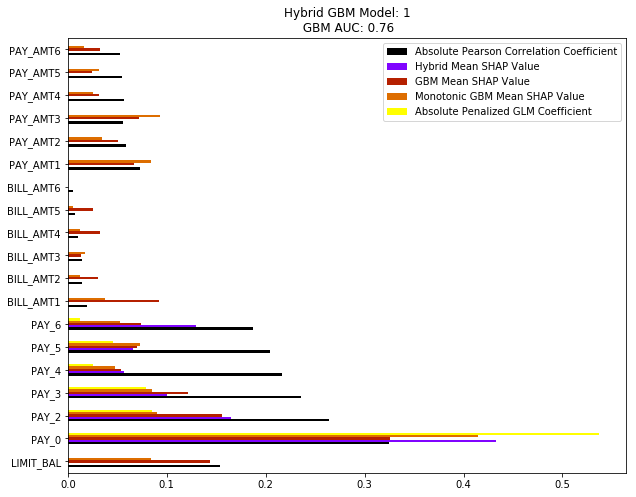

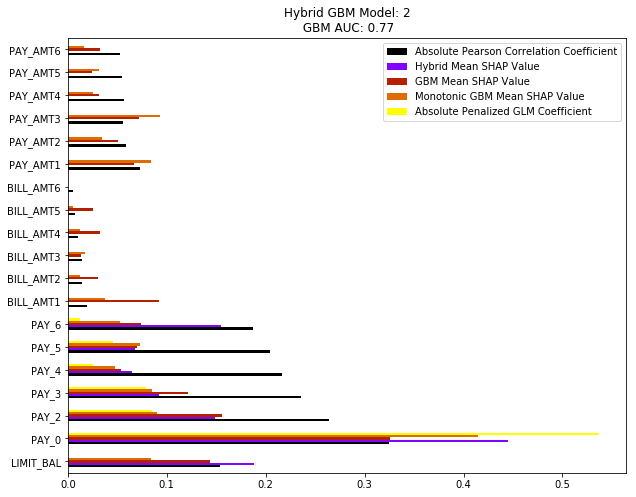

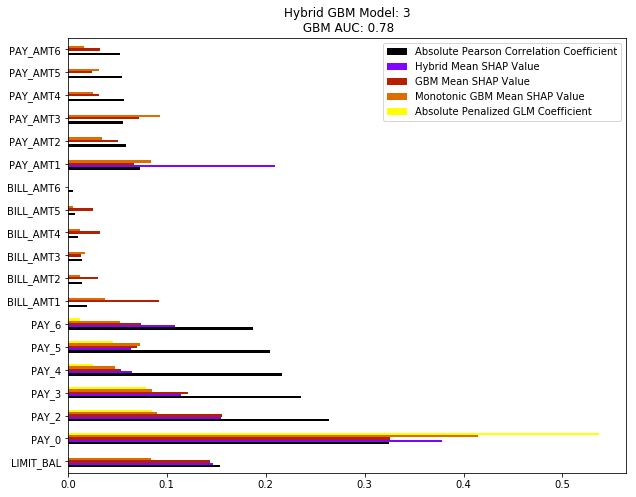

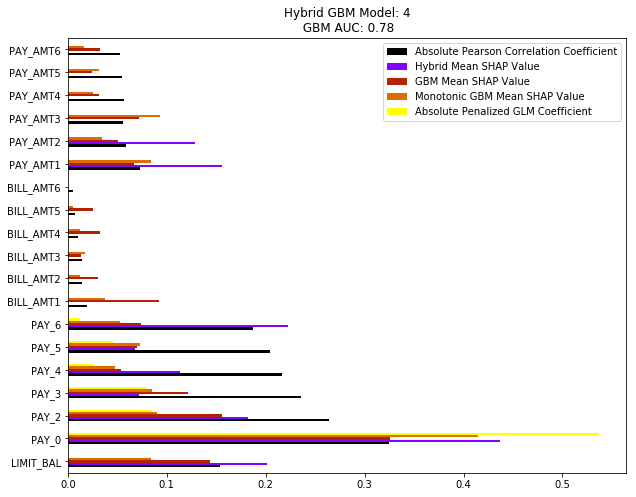

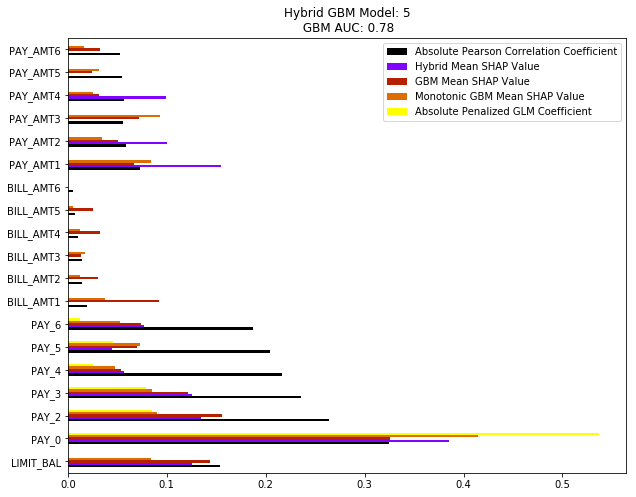

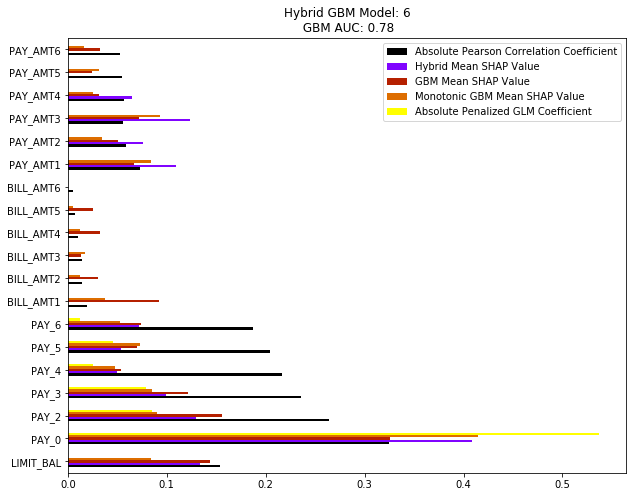

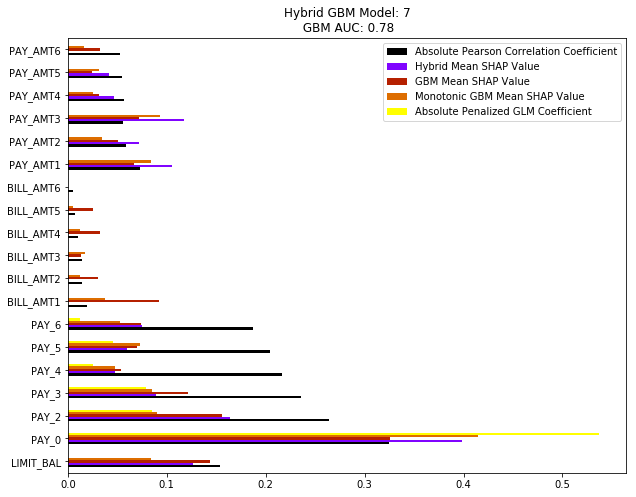

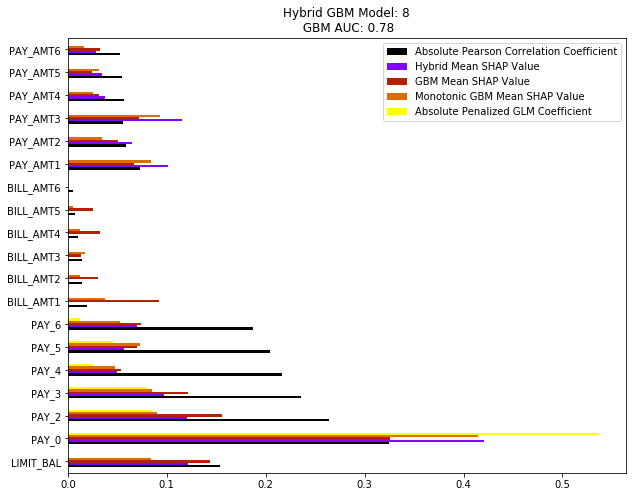

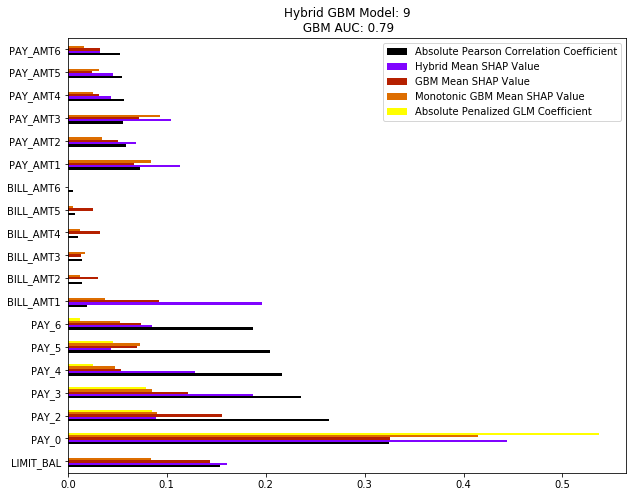

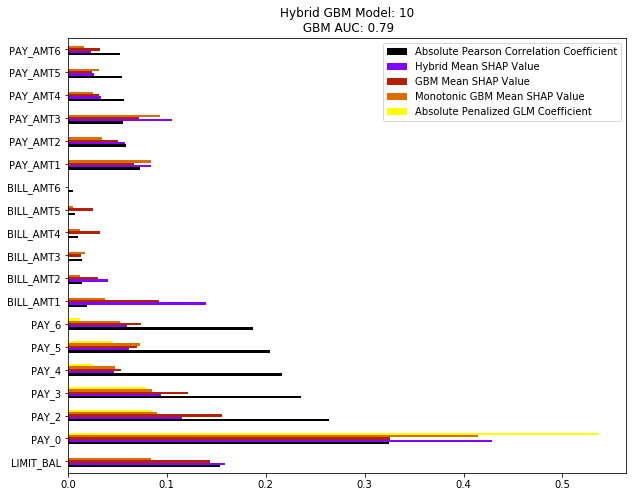

In [36]:
auto_ph.plot_coefs(corr_glm_mgbm_gbm_hybrid_shap_coefs,
                   hybrid_models, 
                   'Hybrid GBM',
                   ['Absolute Pearson Correlation Coefficient',
                    'Hybrid Mean SHAP Value',
                    'GBM Mean SHAP Value',
                    'Monotonic GBM Mean SHAP Value',
                    'Absolute Penalized GLM Coefficient'])

#### Perform cross-validated ranking to select best Hybrid

In [37]:
# autoph cv_model_rank_select function
# requires models to have model_id 
best_gbm.model_id = 'best_gbm'
compare_model_ids = ['best_glm', 'best_mgbm', 'best_gbm']

# start local timer
tic = time.time()

# perform CV rank model selection
best_hybrid, hybrid_selected_coefs, best_hybrid_eval = auto_ph.cv_model_rank_select(valid,
                                                                                    SEED,
                                                                                    corr_glm_mgbm_gbm_hybrid_shap_coefs, 
                                                                                    hybrid_models, 
                                                                                    'hybrid',
                                                                                    compare_model_ids)

# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

# THRESHOLD = 6, hybrid rank = 1.4

Evaluated model 1/10 with rank: 2.88* ...
Evaluated model 2/10 with rank: 2.46* ...
Evaluated model 3/10 with rank: 1.96* ...
Evaluated model 4/10 with rank: 2.24 ...
Evaluated model 5/10 with rank: 2.04 ...
Evaluated model 6/10 with rank: 2.08 ...
Evaluated model 7/10 with rank: 1.92* ...
Evaluated model 8/10 with rank: 1.96 ...
Evaluated model 9/10 with rank: 1.40* ...
Evaluated model 10/10 with rank: 1.64 ...
Done.
Task completed in 947.21 s.


#### Inspect best GBM 

In [38]:
best_hybrid

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  hybrid9


Model Summary: 

number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               50.0                      50.0              20039.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        5.0       14.0        9.72        11.0        40.0        27.14



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13259026736779506
RMSE: 0.36412946511892585
LogLoss: 0.4213987551922327
Mean Per-Class Error: 0.27876019446687894
AUC: 0.7969101065767178
pr_auc: 0.5677983080278433
Gini: 0.5938202131534356

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26746610600951026: 

0       1   Error               Rate
0      0  13877.0  2419.0  0.1484   (2419.0/16296.0)
1      1   1932.0  2718.0  0.4155    (1932.0/4650.0)
2  Total  15809.0  5137.0  0.2077   (4351.0/20946.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold     value    idx
0                       max f1   0.267466  0.555431  206.0
1                       max f2   0.130191  0.654499  308.0
2                 max f0point5   0.423321  0.583887  140.0
3                 max accuracy   0.494949  0.821064  118.0
4                max precision   0.811755  0.907216    5.0
5                   max recall   0.029468  1.000000  396.0
6              max specificity   0.831785  0.999939    0.0
7             max absolute_mcc   0.308632  0.427502  186.0
8   max min_per_class_accuracy   0.192228  0.715484  256.0
9  max mean_per_class_accuracy   0.227657  0.721240  230.0


Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.34 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010026         0.792966  3.796664   
1         2                  0.020004         0.774652  3.599302   
2         3                  0.030030         0.745723  3.303312   
3         4                  0.040008         0.713674  3.232906   
4         5                  0.050033         0.680622  3.281862   
5         6                  0.100019         0.565576  2.882546   
6         7                  0.150005         0.402813  2.275921   
7         8                  0.200038         0.315073  1.779456   
8         9                  0.300010         0.228788  1.243367   
9        10                  0.400029         0.183553  0.918104   
10       11                  0.500000         0.155588  0.770113   
11       12                  0.600019         0.132470  0.642888   
12       13                  0.699990         0.108926  0.544242   
13       14                  0.800010         0.085476  0.337570   
14       15                  0.899981         0.062265  0.191453   
15       16                  1.000000         0.020044  0.161260   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.796664       0.842857  0.808394                  0.842857   
1          3.698218       0.799043  0.783916                  0.821002   
2          3.566374       0.733333  0.760521                  0.791733   
3          3.483206       0.717703  0.730223                  0.773270   
4          3.442860       0.728571  0.696384                  0.764313   
5          3.162837       0.639924  0.622901                  0.702148   
6          2.867292       0.505253  0.484024                  0.636537   
7          2.595203       0.395038  0.354358                  0.576134   
8          2.144735       0.276027  0.266346                  0.476130   
9          1.838040       0.203819  0.205672                  0.408044   
10         1.624516       0.170965  0.168647                  0.360642   
11         1.460885       0.142721  0.143748                  0.324316   
12         1.329972       0.120821  0.120753                  0.295253   
13         1.205900       0.074940  0.097501                  0.267709   
14         1.093213       0.042502  0.073949                  0.242693   
15         1.000000       0.035800  0.048289                  0.221999   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.808394      0.038065                 0.038065  279.666359   
1           0.796184      0.035914                 0.073978  259.930236   
2           0.784277      0.033118                 0.107097  230.331183   
3           0.770796      0.032258                 0.139355  223.290631   
4           0.755885      0.032903                 0.172258  228.186175   
5           0.689425      0.144086                 0.316344  188.254614   
6           0.620980      0.113763                 0.430108  127.592076   
7           0.554292      0.089032                 0.519140   77.945580   
8           0.458341      0.124301                 0.643441   24.336692   
9           0.395166      0.091828                 0.735269   -8.189576   
10          0.349875      0.076989                 0.812258  -22.988693   
11          0.315515      0.064301                 0.876559  -35.711202   
12          0.287700      0.054409                 0.930968  -45.575808   
13          0.263920      0.033763                 0.964731  -66.243006   
14          0.242818      0.019140                 0.983871  -80.854731   
15          0.223361      0.016129                 1.000000  -83.874047   

    cumulative_gain  
0        279.666359  
1        269.821849  
2        256.637366  
3        248.320579  
4        244.286013  
5        216.283686  
6        186.729225  
7        159.520333  
8        114.473461  
9         83.804042  
10        62.451613  
11        46.088540  
12        32.997206  
13    



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13215220532913477
RMSE: 0.3635274478345958
LogLoss: 0.42281097825164826
Mean Per-Class Error: 0.2752114974601497
AUC: 0.7873395816556301
pr_auc: 0.554291424966461
Gini: 0.5746791633112602

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2853538071514341: 

0       1   Error              Rate
0      0  6066.0  1002.0  0.1418   (1002.0/7068.0)
1      1   819.0  1167.0  0.4124    (819.0/1986.0)
2  Total  6885.0  2169.0  0.2011   (1821.0/9054.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold     value    idx
0                       max f1   0.285354  0.561733  198.0
1                       max f2   0.129627  0.639345  310.0
2                 max f0point5   0.428508  0.590686  139.0
3                 max accuracy   0.515985  0.825050  112.0
4                max precision   0.793503  0.817308   12.0
5                   max recall   0.024063  1.000000  399.0
6              max specificity   0.832645  0.999859    0.0
7             max absolute_mcc   0.302980  0.435416  189.0
8   max min_per_class_accuracy   0.196862  0.713998  254.0
9  max mean_per_class_accuracy   0.257099  0.724789  213.0


Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.85 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010051         0.794717  3.707247   
1         2                  0.020102         0.780143  3.506856   
2         3                  0.030042         0.760043  3.140584   
3         4                  0.040093         0.732320  3.306464   
4         5                  0.050033         0.697216  3.292548   
5         6                  0.100066         0.576136  2.958764   
6         7                  0.149989         0.417274  2.430748   
7         8                  0.200022         0.322064  1.690722   
8         9                  0.299978         0.239298  1.203956   
9        10                  0.400044         0.185910  0.860457   
10       11                  0.500000         0.156781  0.664946   
11       12                  0.599956         0.133061  0.609534   
12       13                  0.700022         0.109632  0.543447   
13       14                  0.799978         0.085735  0.357661   
14       15                  0.899934         0.062809  0.327436   
15       16                  1.000000         0.022042  0.196245   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.707247       0.813187  0.810901                  0.813187   
1          3.607052       0.769231  0.787907                  0.791209   
2          3.452706       0.688889  0.770835                  0.757353   
3          3.416045       0.725275  0.747011                  0.749311   
4          3.391509       0.722222  0.714290                  0.743929   
5          3.175137       0.649007  0.635961                  0.696468   
6          2.927372       0.533186  0.504769                  0.642121   
7          2.618039       0.370861  0.368896                  0.574268   
8          2.146852       0.264088  0.277501                  0.470913   
9          1.825075       0.188742  0.212299                  0.400331   
10         1.593152       0.145856  0.170393                  0.349459   
11         1.429276       0.133702  0.144524                  0.313513   
12         1.302649       0.119205  0.121091                  0.285737   
13         1.184575       0.078453  0.098320                  0.259837   
14         1.089372       0.071823  0.074188                  0.238954   
15         1.000000       0.043046  0.048626                  0.219351   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.810901      0.037261                 0.037261  270.724744   
1           0.799404      0.035247                 0.072508  250.685568   
2           0.789951      0.031219                 0.103726  214.058409   
3           0.779187      0.033233                 0.136959  230.646393   
4           0.766293      0.032729                 0.169688  229.254783   
5           0.701127      0.148036                 0.317724  195.876433   
6           0.635771      0.121349                 0.439074  143.074753   
7           0.569015      0.084592                 0.523666   69.072247   
8           0.471880      0.120342                 0.644008   20.395587   
9           0.406949      0.086103                 0.730111  -13.954303   
10          0.359659      0.066465                 0.796576  -33.505366   
11          0.323816      0.060926                 0.857503  -39.046586   
12          0.294837      0.054381                 0.911883  -45.655349   
13          0.270283      0.035750                 0.947633  -64.233947   
14          0.248502      0.032729                 0.980363  -67.256430   
15          0.228502      0.019637                 1.000000  -80.375543   

    cumulative_gain  
0        270.724744  
1        260.705156  
2        245.270570  
3        241.604454  
4        239.150877  
5        217.513655  
6        192.737231  
7        161.803914  
8        114.685160  
9         82.507536  
10        59.315206  
11        42.927610  
12        30.264915  
13    



Scoring History: 

timestamp           duration  number_of_trees  training_rmse  \
0     2020-04-22 15:33:51   8 min 26.319 sec              0.0       0.415591   
1     2020-04-22 15:33:51   8 min 26.361 sec              1.0       0.409506   
2     2020-04-22 15:33:51   8 min 26.397 sec              2.0       0.404916   
3     2020-04-22 15:33:51   8 min 26.426 sec              3.0       0.404052   
4     2020-04-22 15:33:51   8 min 26.467 sec              4.0       0.404029   
5     2020-04-22 15:33:51   8 min 26.556 sec              5.0       0.397683   
6     2020-04-22 15:33:51   8 min 26.616 sec              6.0       0.394077   
7     2020-04-22 15:33:51   8 min 26.672 sec              7.0       0.391791   
8     2020-04-22 15:33:52   8 min 26.742 sec              8.0       0.387573   
9     2020-04-22 15:33:52   8 min 26.796 sec              9.0       0.385935   
10    2020-04-22 15:33:52   8 min 26.850 sec             10.0       0.382839   
11    2020-04-22 15:33:52   8 min 26.905 sec             11.0       0.380309   
12    2020-04-22 15:33:52   8 min 26.958 sec             12.0       0.379383   
13    2020-04-22 15:33:52   8 min 27.031 sec             13.0       0.377253   
14    2020-04-22 15:33:52   8 min 27.096 sec             14.0       0.375562   
15    2020-04-22 15:33:52   8 min 27.150 sec             15.0       0.374235   
16    2020-04-22 15:33:52   8 min 27.196 sec             16.0       0.373553   
17    2020-04-22 15:33:52   8 min 27.248 sec             17.0       0.372623   
18    2020-04-22 15:33:52   8 min 27.303 sec             18.0       0.371555   
19    2020-04-22 15:33:52   8 min 27.361 sec             19.0       0.371202   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.529427      0.500000         0.000000       1.000000   
1           0.515866      0.684760         0.455246       3.523028   
2           0.506025      0.749735         0.485649       3.596762   
3           0.505076      0.719029         0.468992       3.596762   
4           0.505586      0.709603         0.464296       3.596762   
5           0.493206      0.726924         0.480326       3.596762   
6           0.486052      0.740493         0.498806       3.576221   
7           0.481404      0.749614         0.499939       3.629231   
8           0.473196      0.761414         0.531365       3.680029   
9           0.469643      0.766140         0.533438       3.716731   
10          0.463622      0.770406         0.538970       3.746938   
11          0.458645      0.772977         0.541487       3.720397   
12          0.456539      0.773290         0.540536       3.689413   
13          0.452186      0.776596         0.544348       3.723491   
14          0.448758      0.778260         0.546167       3.683600   
15          0.445859      0.780456         0.547347       3.753763   
16          0.444802      0.780335         0.548536       3.821367   
17          0.442652      0.781238         0.549017       3.818114   
18          0.440210      0.783156         0.550889       3.806633   
19          0.439258      0.783213         0.549972       3.796664   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.778001         0.413815            0.526105   
1                        0.190824         0.407433            0.511967   
2                        0.215745         0.402656            0.501819   
3                        0.202712         0.401993            0.501383   
4                        0.203332         0.402090            0.502174   
5                        0.208870         0.395418            0.489276   
6                        0.203523         0.391674            0.481895   
7                        0.197078         0.389288            0.477090   
8                        0.223241         0.384944            0.468748   
9                        0.225771         0.383364            0.465355   
10                       0.213836         0.380089


See the whole table with table.as_data_frame()

Variable Importances: 

variable  relative_importance  scaled_importance  percentage
0       PAY_0          2558.588867           1.000000    0.498923
1       PAY_3           688.551086           0.269114    0.134267
2       PAY_2           350.810608           0.137111    0.068408
3       PAY_4           332.122284           0.129807    0.064764
4   BILL_AMT1           291.351929           0.113872    0.056813
5    PAY_AMT1           168.537277           0.065871    0.032865
6   LIMIT_BAL           167.566696           0.065492    0.032675
7       PAY_6           141.123337           0.055157    0.027519
8    PAY_AMT3           139.932648           0.054691    0.027287
9       PAY_5           108.442436           0.042384    0.021146
10   PAY_AMT2            70.692581           0.027630    0.013785
11   PAY_AMT4            42.055202           0.016437    0.008201
12   PAY_AMT6            40.320015           0.015759    0.007862
13   PAY_AMT5            28.128548           0.010994    0.005485

#### Assess best GBM ranking

In [39]:
best_hybrid_eval

Fold    Metric  best_glm Value  best_mgbm Value  best_gbm Value  \
0     0        F1        0.533181         0.551298        0.562353   
1     0  accuracy        0.816246         0.817367        0.814006   
2     0       auc        0.738625         0.776026        0.777570   
3     0   logloss        0.468678         0.440775        0.438078   
4     0       mcc        0.419924         0.420105        0.426918   
5     1        F1        0.540865         0.554762        0.555283   
6     1  accuracy        0.823882         0.826063        0.828244   
7     1       auc        0.729674         0.776877        0.785956   
8     1   logloss        0.465999         0.434170        0.428677   
9     1       mcc        0.432722         0.445354        0.447637   
10    2        F1        0.500593         0.516364        0.530343   
11    2  accuracy        0.830907         0.833707        0.835946   
12    2       auc        0.707507         0.760838        0.769493   
13    2   logloss        0.459017         0.420930        0.417171   
14    2       mcc        0.395476         0.409254        0.411118   
15    3        F1        0.531328         0.550251        0.557500   
16    3  accuracy        0.834578         0.836713        0.835112   
17    3       auc        0.733536         0.782795        0.791644   
18    3   logloss        0.448512         0.416031        0.411094   
19    3       mcc        0.426465         0.443411        0.445759   
20    4        F1        0.561589         0.587666        0.593037   
21    4  accuracy        0.820845         0.829296        0.826479   
22    4       auc        0.740132         0.790550        0.803337   
23    4   logloss        0.467037         0.427654        0.419666   
24    4       mcc        0.448005         0.463860        0.472417   

    hybrid9 Value  best_gbm Rank  best_glm Rank  best_mgbm Rank  hybrid9 Rank  
0        0.565875            2.0            4.0             3.0           1.0  
1        0.812885            3.0            2.0             1.0           4.0  
2        0.780667            2.0            4.0             3.0           1.0  
3        0.437294            2.0            4.0             3.0           1.0  
4        0.427220            2.0            4.0             3.0           1.0  
5        0.563446            2.0            4.0             3.0           1.0  
6        0.828790            2.0            4.0             3.0           1.0  
7        0.787909            2.0            4.0             3.0           1.0  
8        0.427742            2.0            4.0             3.0           1.0  
9        0.453102            2.0            4.0             3.0           1.0  
10       0.531017            2.0            4.0             3.0           1.0  
11       0.833147            1.0            4.0             2.0           3.0  
12       0.767894            1.0            4.0             3.0           2.0  
13       0.419599            1.0            4.0             3.0           2.0  
14       0.414319            2.0            4.0             3.0           1.0  
15       0.567164            2.0            4.0             3.0           1.0  
16       0.836179            3.0            4.0             1.0           2.0  
17       0.795031            2.0            4.0             3.0           1.0  
18       0.409044            2.0            4.0             3.0           1.0  
19       0.452049            2.0            4.0             3.0           1.0  
20       0.597087            2.0            4.0             3.0           1.0  
21       0.827606            3.0            4.0             1.0           2.0  
22       0.803346            2.0            4.0             3.0           1.0  
23       0.420917            1.0            4.0             3.0           2.0  
24       0.475800            2.0            4.0             3.0           1.0

#### Print mean rank for each model

In [40]:
print('Best GLM mean rank:', best_hybrid_eval['best_glm Rank'].mean())
print('Best MGBM mean rank:', best_hybrid_eval['best_mgbm Rank'].mean())
print('Best GBM mean rank:', best_hybrid_eval['best_gbm Rank'].mean())
print('Best Hybrid mean rank:', best_hybrid_eval['hybrid9 Rank'].mean())

Best GLM mean rank: 3.92
Best MGBM mean rank: 2.72
Best GBM mean rank: 1.96
Best Hybrid mean rank: 1.4


#### Calculate partial dependence for each feature in best GBM

In [41]:
# init dict to hold partial dependence and ICE values
# for each feature
# for hybrid gbm
hybrid_pd_ice_dict = {}

# establish hybrid gbm selected features
hybrid_selected = list(hybrid_selected_coefs[hybrid_selected_coefs['Hybrid Mean SHAP Value'] != 0].index)

# calculate partial dependence for each selected feature
for xs in hybrid_selected:
    hybrid_pd_ice_dict[xs] = auto_ph.pd_ice(xs, valid, best_hybrid)

#### Find some percentiles of yhat in the validation data

In [42]:
# merge hybrid predictions onto validation data
hybrid_yhat_valid = pd.concat([valid.reset_index(drop=True),
                               best_hybrid.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                              axis=1)

# rename yhat column
hybrid_yhat_valid = hybrid_yhat_valid.rename(columns={'p1':'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
hybrid_percentile_dict = auto_ph.get_percentile_dict('p_DEFAULT_NEXT_MONTH', hybrid_yhat_valid, 'ID')

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
hybrid_percentile_dict

{0: 27993,
 99: 12011,
 10: 1287,
 20: 22782,
 30: 20906,
 40: 15292,
 50: 13621,
 60: 29078,
 70: 25804,
 80: 28945,
 90: 18250}

In [43]:
set(hybrid_mono_dict.keys()) - set(hybrid_selected) # ?? this is one off from expected ...

{'BILL_AMT2', 'BILL_AMT3'}

#### Calculate ICE curve values

In [44]:
# loop through selected variables
for xs in hybrid_selected: 

    # collect bins used in partial dependence
    bins = list(hybrid_pd_ice_dict[xs][xs])

    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature    
    for i in sorted(hybrid_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        hybrid_pd_ice_dict[xs][col_name] = auto_ph.pd_ice(xs, 
                                                          valid[valid['ID'] == int(hybrid_percentile_dict[i])][hybrid_selected], 
                                                          best_hybrid, 
                                                          bins=bins)['partial_dependence']

#### Assess partial dependence and ICE for each feature in best hybrid

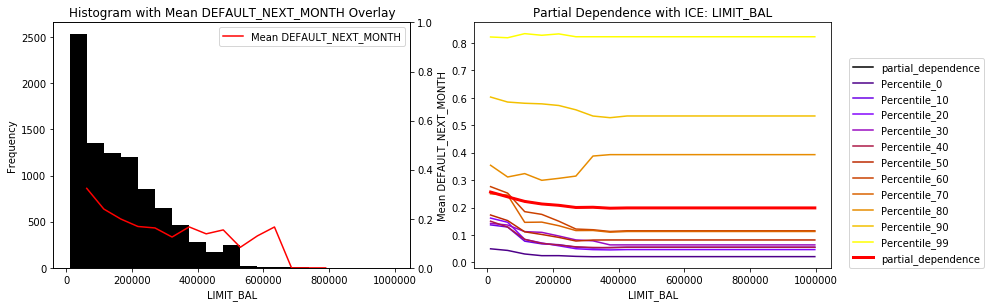

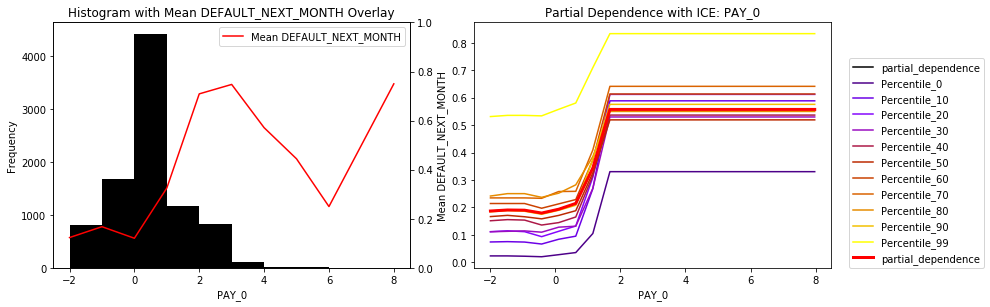

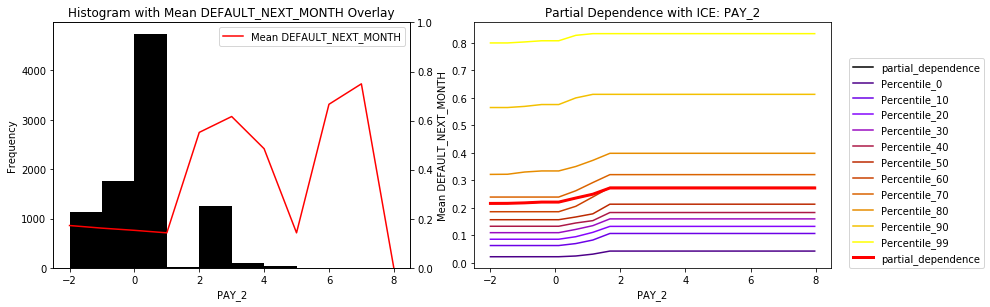

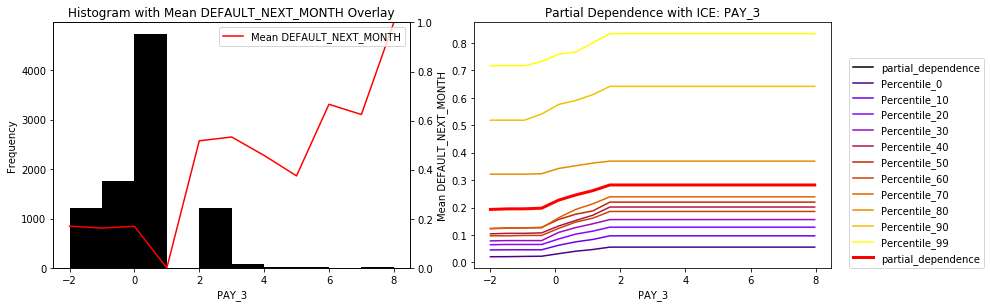

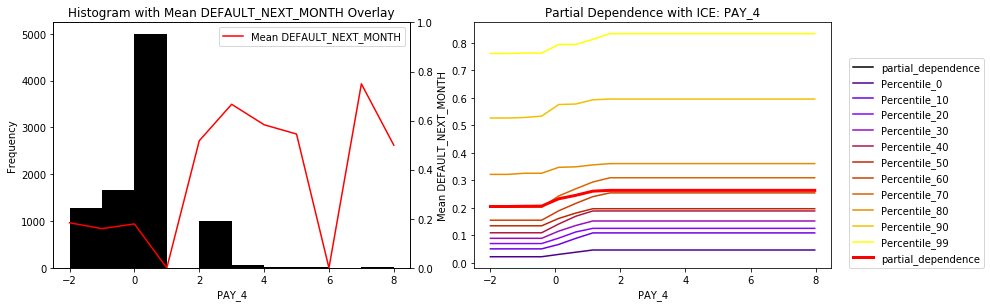

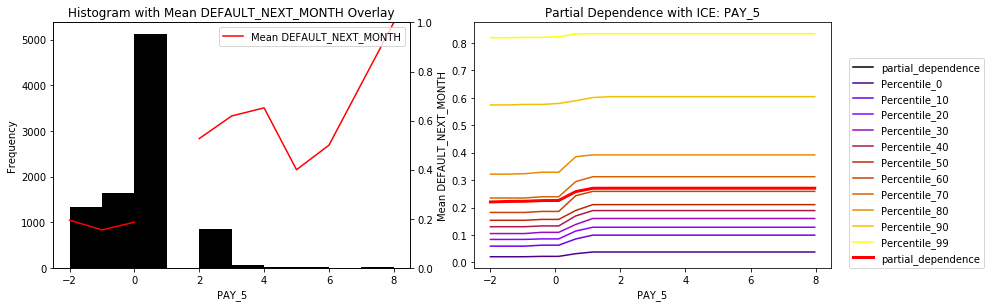

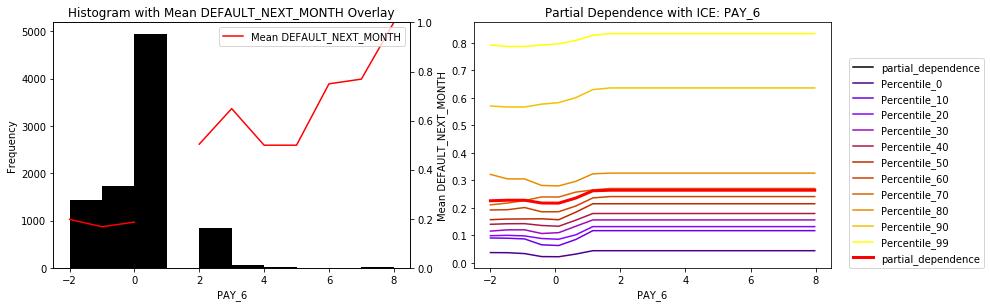

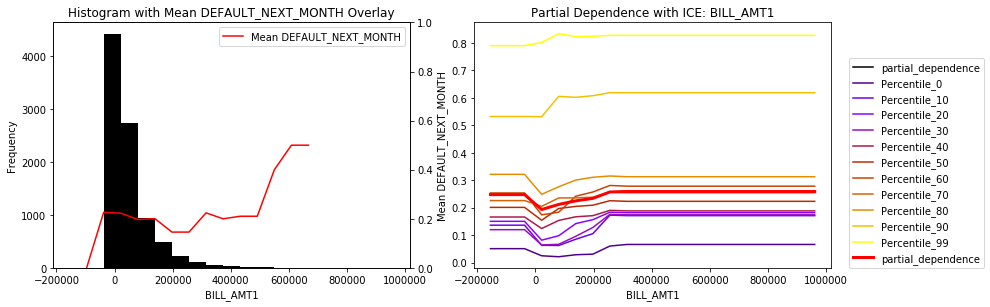

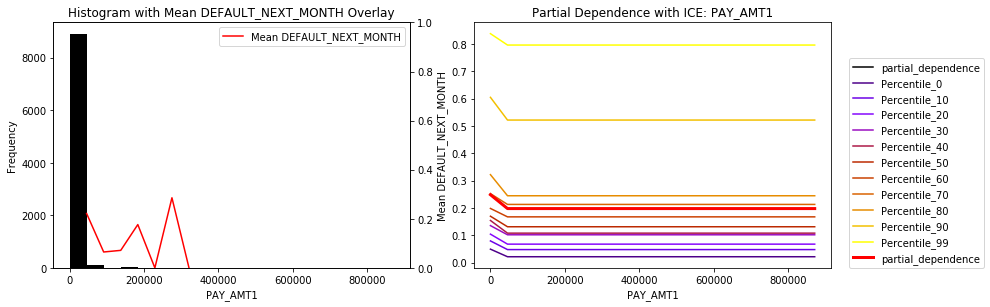

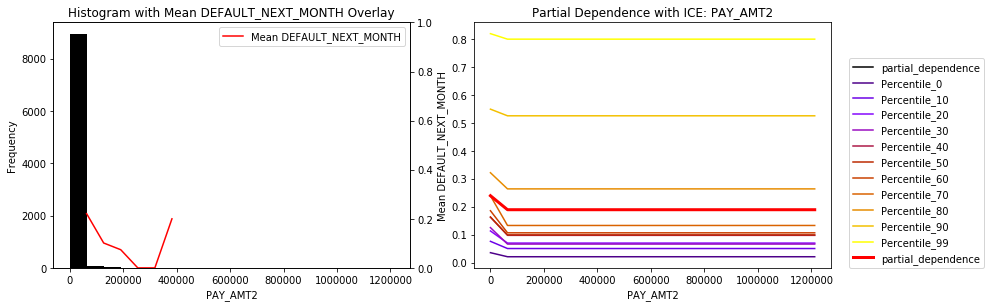

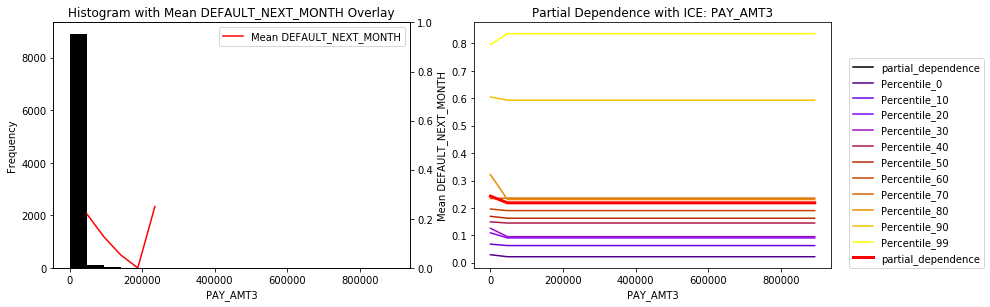

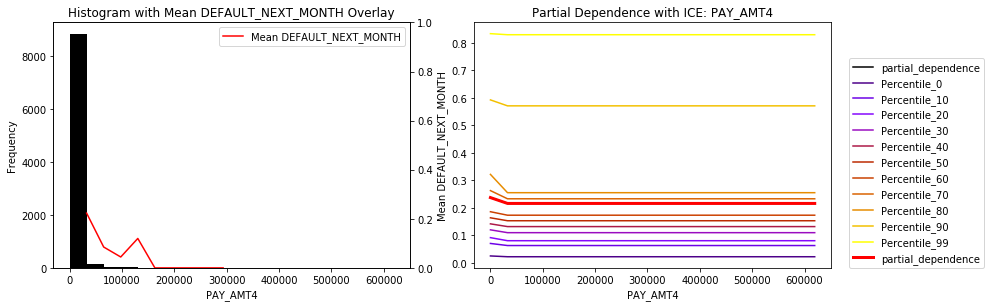

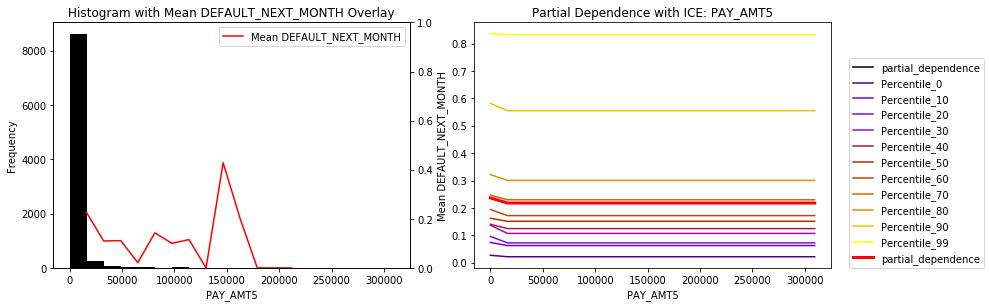

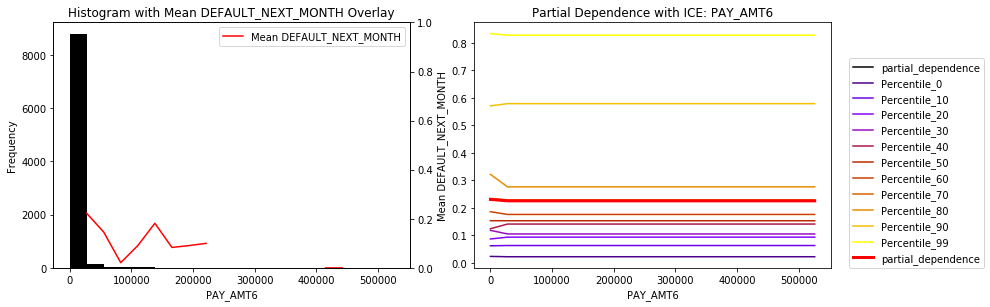

In [45]:
for xs in hybrid_selected: 
    auto_ph.hist_mean_pd_ice_plot(xs, y_name, valid, hybrid_pd_ice_dict)

#### End global timer

In [46]:
big_toc = time.time() - big_tic
print('All tasks completed in %.2f s.' % (big_toc))

All tasks completed in 10175.66 s.


#### Shutdown H2O

In [47]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? n
